# Installing Dependicies
In this section, with a file named "dependencies.txt", we're checking to see if all needed packages are installed, if not, force "pip install" them.

It's assumed "dependencies.txt" has the following format:
- Every line refers to 1 library

If there's any doubt regarding the format of said file, use the following as an example:
```
    matplotlib
    shutil
    random
    tensorflow
    opencv-python
```

In [1]:
import importlib.util
import sys


with open('dependencies.txt', 'r') as f:
    for dependency in f.readline():
        dependency = dependency.replace('\n', '')
        # If installed OR not found, continue
        if (dependency in sys.modules )or ((spec := importlib.util.find_spec(dependency)) is None): continue

        module = importlib.util.module_from_spec(spec)
        sys.modules[dependency] = module
        spec.loader.exec_module(module)


# Assignment Tasks

## Task 1
Task: Go to the tutorial <a href="https://machinelearningmastery.com/how-to-develop-a-convolutional-neural-network-to-classify-photos-of-dogs-and-cats/">found here</a> and repeat the whole process

In the next code section, a few notes need to be assessed:

- This section will create a few files so permission for writting is needed and it will duplicate the training set in order to test the model
- it's assumed a few things regarding file structure in the project directory, it should go as follows:
```
    project_folder
    │   dependencies.txt
    │   notebook.ipynb
    │   ... [any other files]
    │
    └───Data
    │   │
    │   └───cats_and_dogs
    │   │    │
    │   │    └───train
    │   │    │   │    cat.*  
    │   │    │   │    dog.*
    │   │    │
    │   │    └───test
    │   │        │    ... [photos with cats/dogs]
    │   │
    │   │
    │   └───pandas [folder used for Task 5]
    │ ...
```

### Importing necessary packages

In [1]:
import os
import sys
import tqdm
import time
import shutil
import numpy as np
import random as rnd
import seaborn as sns


from matplotlib import pyplot
from matplotlib.image import imread


from keras.models import Model
from keras.models import Sequential

from keras.optimizers import SGD

from keras.applications.vgg16 import VGG16

from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import MaxPooling2D

from keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

### Plotting Images of dogs and cats dataset

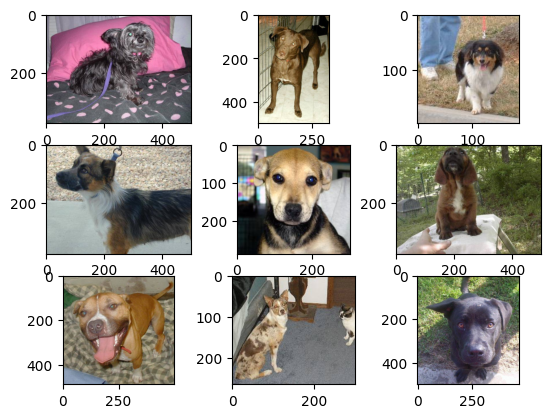

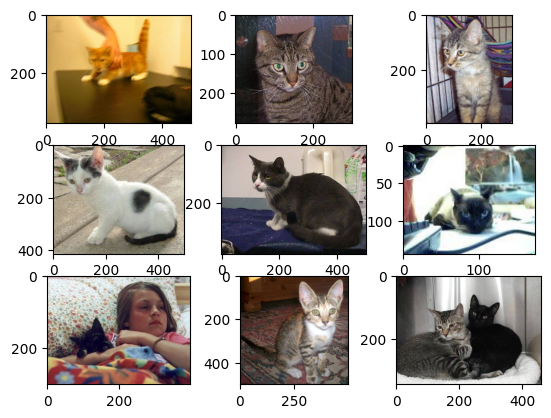

In [2]:
start = time.time()
# define location of dataset
folder = 'data/cats_and_dogs/train/'
# plot first few images
for i in range(9):
	# define subplot
	pyplot.subplot(330 + 1 + i)
	# plot raw pixel data
	pyplot.imshow(imread(folder + 'dog.' + str(i) + '.jpg'))
# show the figure
pyplot.show()
# plot first few images
for i in range(9):
	# define subplot
	pyplot.subplot(330 + 1 + i)
	# plot raw pixel data
	pyplot.imshow(imread(folder + 'cat.' + str(i) + '.jpg'))
# show the figure
pyplot.show()


### Organizing dataset into a useful Structure

It's necessary, prior to testing on the "real test", to fine tude the model and, in order to do so, it's necessary to pick on the labeled data and divide it in "train" and "test" [to check if model is a good one]

In [4]:
# create directories
dataset_home = 'data/dataset_dogs_vs_cats/'
subdirs = ['train/', 'test/']
for subdir in subdirs:
	# create label subdirectories
	labeldirs = ['dogs/', 'cats/']
	for labldir in labeldirs:
		newdir = dataset_home + subdir + labldir
		os.makedirs(newdir, exist_ok=True)
# seed random number generator
rnd.seed(1)
# define ratio of pictures to use for validation
val_ratio = 0.25
# copy training dataset images into subdirectories
src_directory = 'data/cats_and_dogs/train/'
for file in tqdm.tqdm(os.listdir(src_directory), desc='Copying files to new folders'):
	src = src_directory + '/' + file
	dst_dir = 'train/'
	if rnd.random() < val_ratio:
		dst_dir = 'test/'
	if file.startswith('cat'):
		dst = dataset_home + dst_dir + 'cats/'  + file
		shutil.copyfile(src, dst)
	elif file.startswith('dog'):
		dst = dataset_home + dst_dir + 'dogs/'  + file
		shutil.copyfile(src, dst)


Copying files to new folders: 100%|██████████| 25000/25000 [00:23<00:00, 1062.99it/s]


### Modeling the problem

#### Plotting Data
Function which plots the data in order to summarize everything

In [3]:
def summarize_diagnostics(history):
	# plot diagnostic learning curves

	# plot loss
	pyplot.subplot(211)
	pyplot.title('Cross Entropy Loss')
	pyplot.plot(history.history['loss'], color='blue', label='train')
	pyplot.plot(history.history['val_loss'], color='orange', label='test')
	# plot accuracy
	pyplot.subplot(212)
	pyplot.title('Classification Accuracy')
	pyplot.plot(history.history['accuracy'], color='blue', label='train')
	pyplot.plot(history.history['val_accuracy'], color='orange', label='test')
	# save plot to file
	filename = os.getcwd() + '\\outputs\\plot_{x}.png'.format(x=len(os.listdir('outputs')))
	pyplot.tight_layout()
	pyplot.show()
	pyplot.savefig(filename)
	pyplot.close()

#### Baseline model

This first model will set the baseline for the next models tested,
- One Block VGG Model 
- converts the images to a (200x200) resolution [it requires images to be all the same resolution]

<24.93 sec> :: Start One Block VGG Model
Found 18697 images belonging to 2 classes.
Found 6303 images belonging to 2 classes.
> 73.584


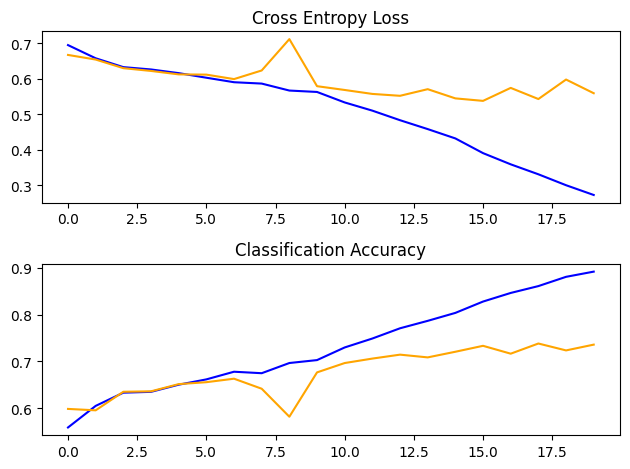

<567.10 sec> :: Finished One Block VGG Model


In [6]:
dataset_home = 'data/dataset_dogs_vs_cats/'

# define cnn model
def define_model():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(200, 200, 3)))
	model.add(MaxPooling2D((2, 2)))
	model.add(Flatten())
	model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = SGD(learning_rate=0.001, momentum=0.9)
	model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
	return model

# run the test harness for evaluating a model
def run_test_harness():
	# define model
	model = define_model()
	# create data generator
	datagen = ImageDataGenerator(rescale=1.0/255.0)
	# prepare iterators
	train_it = datagen.flow_from_directory(f'{dataset_home}/train/',
		class_mode='binary', batch_size=64, target_size=(200, 200))
	test_it = datagen.flow_from_directory(f'{dataset_home}/test/',
		class_mode='binary', batch_size=64, target_size=(200, 200))
	# fit model
	history = model.fit(train_it, steps_per_epoch=len(train_it),
		validation_data=test_it, validation_steps=len(test_it), epochs=20, verbose=0)
	
	# evaluate model
	_, acc = model.evaluate(test_it, steps=len(test_it), verbose=0)
	print('> %.3f' % (acc * 100.0))
	# learning curves
	summarize_diagnostics(history)

	
    

print(f"<{time.time()-start:.2f} sec> :: Start One Block VGG Model")
# entry point, run the test harness
run_test_harness()
print(f"<{time.time()-start:.2f} sec> :: Finished One Block VGG Model")

#### Baseline model with data augmentation

This first model will set the baseline for the next models tested,
- Three Block VGG Model 
- Data augmentation with "horizontal_flip" + "width" + "Height" shift
- converts the images to a (200x200) resolution [it requires images to be all the same resolution]

<567.17 sec> :: Start One Block VGG Model
Found 18697 images belonging to 2 classes.
Found 6303 images belonging to 2 classes.
> 85.134


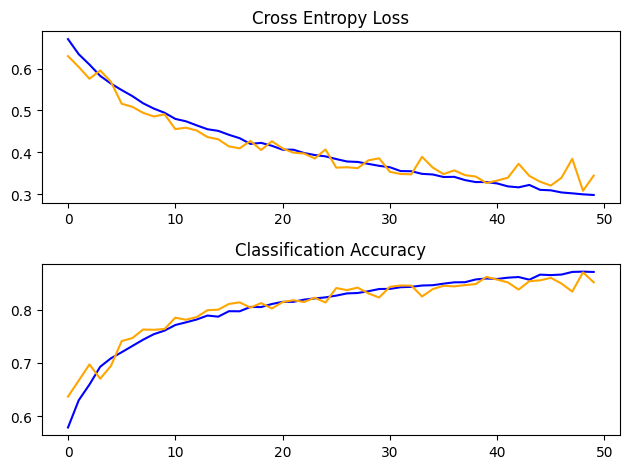

<5637.11 sec> :: Finished One Block VGG Model


In [7]:
# define cnn model
def define_model():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(200, 200, 3)))
	model.add(MaxPooling2D((2, 2)))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Flatten())
	model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = SGD(learning_rate=0.001, momentum=0.9)
	model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
	return model

# run the test harness for evaluating a model
def run_test_harness():
	# define model
	model = define_model()
	# create data generators
	train_datagen = ImageDataGenerator(rescale=1.0/255.0,
		width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
	test_datagen = ImageDataGenerator(rescale=1.0/255.0)
	# prepare iterators
	train_it = train_datagen.flow_from_directory(f'{dataset_home}/train/',
		class_mode='binary', batch_size=64, target_size=(200, 200))
	test_it = test_datagen.flow_from_directory(f'{dataset_home}/test/',
		class_mode='binary', batch_size=64, target_size=(200, 200))
	# fit model
	history = model.fit(train_it, steps_per_epoch=len(train_it),
		validation_data=test_it, validation_steps=len(test_it), epochs=50, verbose=0)
	# evaluate model
	_, acc = model.evaluate(test_it, steps=len(test_it), verbose=0)
	print('> %.3f' % (acc * 100.0))
	# learning curves
	summarize_diagnostics(history)

print(f"<{time.time()-start:.2f} sec> :: Start One Block VGG Model")
# entry point, run the test harness
run_test_harness()
print(f"<{time.time()-start:.2f} sec> :: Finished One Block VGG Model")

#### Baseline model with dropout regularization

This first model will set the baseline for the next models tested,
- Three Block VGG Model 
- Each block has a dropout regularization of 20% and a dropout rate of 50% applied after the fully connected layer in the classifier part of the model
- converts the images to a (200x200) resolution [it requires images to be all the same resolution]

<5637.16 sec> :: Start Three Blocks VGG with Dropout
Found 18697 images belonging to 2 classes.
Found 6303 images belonging to 2 classes.
> 82.120


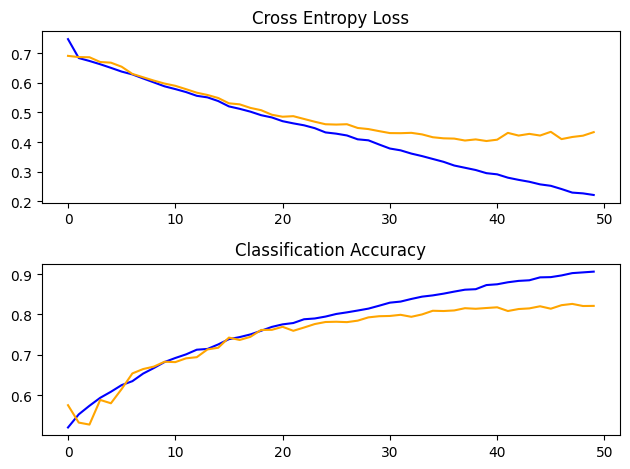

<6906.99 sec> :: Finished Three Blocks VGG with Dropout


In [8]:
# define cnn model
def define_model():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(200, 200, 3)))
	model.add(MaxPooling2D((2, 2)))
	model.add(Dropout(0.2))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Dropout(0.2))
	model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Dropout(0.2))
	model.add(Flatten())
	model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dropout(0.5))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = SGD(learning_rate=0.001, momentum=0.9)
	model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
	return model

# run the test harness for evaluating a model
def run_test_harness():
	# define model
	model = define_model()
	# create data generator
	datagen = ImageDataGenerator(rescale=1.0/255.0)
	# prepare iterator
	train_it = datagen.flow_from_directory(f'{dataset_home}/train/',
		class_mode='binary', batch_size=64, target_size=(200, 200))
	test_it = datagen.flow_from_directory(f'{dataset_home}/test/',
		class_mode='binary', batch_size=64, target_size=(200, 200))
	# fit model
	history = model.fit(train_it, steps_per_epoch=len(train_it),
		validation_data=test_it, validation_steps=len(test_it), epochs=50, verbose=0)
	# evaluate model
	_, acc = model.evaluate(test_it, steps=len(test_it), verbose=0)
	print('> %.3f' % (acc * 100.0))
	# learning curves
	summarize_diagnostics(history)


print(f"<{time.time()-start:.2f} sec> :: Start Three Blocks VGG with Dropout")
# entry point, run the test harness
run_test_harness()
print(f"<{time.time()-start:.2f} sec> :: Finished Three Blocks VGG with Dropout")

###it may also be interesting to explore perhaps a slightly higher dropout rate after the VGG blocks in addition to the increase in training epochs.

#### VGG16 Model    

In this example it is explored a different model, VGG16, which is divided into 2 parts:
- The feature extractor part of the model that is made up of VGG blocks
- The classifier part of the model that is made up of fully connected layers and the output layer

With this model, it is expected an image shape of 244x244 pixels and it's necessary to explicitly mension the mean pixel values, which were obtained at the tutorial of this Task.

<6907.05 sec> :: Start Model VGG16
Found 18697 images belonging to 2 classes.
Found 6303 images belonging to 2 classes.
Epoch 1/10
585/585 [==============================] - 72s 116ms/step - loss: 0.2267 - accuracy: 0.9643 - val_loss: 0.0650 - val_accuracy: 0.9743
Epoch 2/10
585/585 [==============================] - 62s 107ms/step - loss: 0.0256 - accuracy: 0.9912 - val_loss: 0.0687 - val_accuracy: 0.9786
Epoch 3/10
585/585 [==============================] - 62s 106ms/step - loss: 0.0080 - accuracy: 0.9975 - val_loss: 0.0958 - val_accuracy: 0.9767
Epoch 4/10
585/585 [==============================] - 62s 107ms/step - loss: 0.0021 - accuracy: 0.9995 - val_loss: 0.1093 - val_accuracy: 0.9776
Epoch 5/10
585/585 [==============================] - 62s 107ms/step - loss: 6.7423e-04 - accuracy: 0.9998 - val_loss: 0.1195 - val_accuracy: 0.9787
Epoch 6/10
585/585 [==============================] - 62s 107ms/step - loss: 3.3188e-04 - accuracy: 1.0000 - val_loss: 0.1235 - val_accuracy: 0.9791
Ep

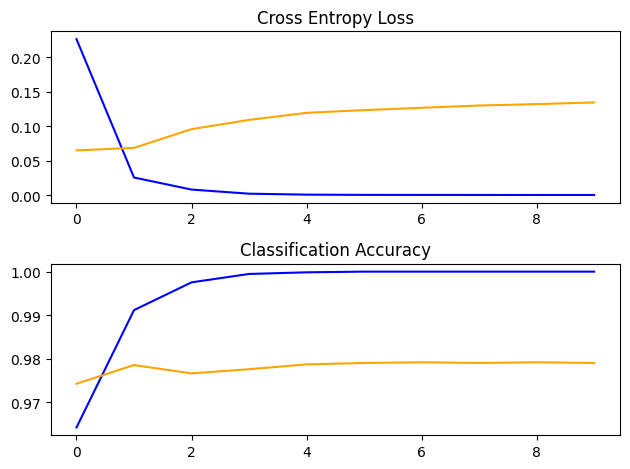

<7557.63 sec> :: Finished Model VGG16


In [9]:
def define_model():
	# load model
	model = VGG16(include_top=False, input_shape=(224, 224, 3))
	# mark loaded layers as not trainable
	for layer in model.layers:
		layer.trainable = False
	# add new classifier layers
	flat1 = Flatten()(model.layers[-1].output)
	class1 = Dense(128, activation='relu', kernel_initializer='he_uniform')(flat1)
	output = Dense(1, activation='sigmoid')(class1)
	# define new model
	model = Model(inputs=model.inputs, outputs=output)
	# compile model
	opt = SGD(learning_rate=0.001, momentum=0.9)
	model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
	return model

# run the test harness for evaluating a model
def run_test_harness():
	# define model
	model = define_model()
	# create data generator
	datagen = ImageDataGenerator(featurewise_center=True)
	# specify imagenet mean values for centering
	datagen.mean = [123.68, 116.779, 103.939]
	# prepare iterator
	train_it = datagen.flow_from_directory(f'{dataset_home}/train/',
		class_mode='binary', batch_size=32, target_size=(224, 224))
	test_it = datagen.flow_from_directory(f'{dataset_home}/test/',
		class_mode='binary', batch_size=32, target_size=(224, 224))
	# fit model
	history = model.fit(train_it, steps_per_epoch=len(train_it),
		validation_data=test_it, validation_steps=len(test_it), epochs=10, verbose=1)
	# evaluate model
	_, acc = model.evaluate(test_it, steps=len(test_it), verbose=0)
	print('> %.3f' % (acc * 100.0))
	# learning curves
	summarize_diagnostics(history)
	return model


print(f"<{time.time()-start:.2f} sec> :: Start Model VGG16")
# entry point, run the test harness
model = run_test_harness()
print(f"<{time.time()-start:.2f} sec> :: Finished Model VGG16")

### Using best model to run on the total Training dataset

After fine-tunning the model with the training set, it's time to run on the "real" dataset

This section of the code stores the model on a file named "final_model.h5"

In [10]:
# organize dataset into a useful structure
# create directories
dataset_home = 'data/finalize_dogs_vs_cats/'
# create label subdirectories
labeldirs = ['dogs/', 'cats/']
for labldir in labeldirs:
	newdir = dataset_home + labldir
	os.makedirs(newdir, exist_ok=True)
# copy training dataset images into subdirectories
src_directory = 'data/cats_and_dogs/train/'
for file in tqdm.tqdm(os.listdir(src_directory), desc='Copying files to new folders'):
	src = src_directory + '/' + file
	if file.startswith('cat'):
		dst = dataset_home + 'cats/'  + file
		shutil.copyfile(src, dst)
	elif file.startswith('dog'):
		dst = dataset_home + 'dogs/'  + file
		shutil.copyfile(src, dst)
        



# define cnn model
def define_model():
	# load model
	model = VGG16(include_top=False, input_shape=(224, 224, 3))
	# mark loaded layers as not trainable
	for layer in model.layers:
		layer.trainable = False
	# add new classifier layers
	flat1 = Flatten()(model.layers[-1].output)
	class1 = Dense(128, activation='relu', kernel_initializer='he_uniform')(flat1)
	output = Dense(1, activation='sigmoid')(class1)
	# define new model
	model = Model(inputs=model.inputs, outputs=output)
	# compile model
	opt = SGD(learning_rate=0.001, momentum=0.9)
	model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
	return model

# run the test harness for evaluating a model
def run_test_harness():
# define model
	model = define_model()
	# create data generator
	datagen = ImageDataGenerator(featurewise_center=True)
	# specify imagenet mean values for centering
	datagen.mean = [123.68, 116.779, 103.939]
	# prepare iterator
	train_it = datagen.flow_from_directory(dataset_home,
		class_mode='binary', batch_size=64, target_size=(224, 224))
	# fit model
	model.fit(train_it, steps_per_epoch=len(train_it), epochs=10, verbose=0)
	# save model
	model.save('final_model.h5')

print(f"<{time.time()-start:.2f} sec> :: Start Harness")
# entry point, run the test harness
run_test_harness()
print(f"<{time.time()-start:.2f} sec> :: Finished Harness")

Copying files to new folders: 100%|██████████| 25000/25000 [00:30<00:00, 816.88it/s] 


<7588.36 sec> :: Start Harness
Found 25000 images belonging to 2 classes.
<8209.60 sec> :: Finished Harness


## Task 2
Task: Create new images containing noise (for example, Gaussian white noise) or mask the images placing some blocking artifact.

In this section, the same structure as in [Task 1](#task-1) is assumed.

We decided on creating new images with Gaussian White noise

### Importing necessary packages

In [11]:
import cv2 
from scipy.stats import gaussian_kde

### Generating New Images
In this section, we are going to generate a new set of images from the training set images, with a given probability, and adding some Gaussian White Noise.

In [12]:
# seed random number generator
rnd.seed(1)
# define ratio of pictures to use for generating new images
val_ratio = 0.25

def generate_gaussian_noise(file, output_file):
    # original image
    f = cv2.imread(file)
    f = f/255 # turning each pixel in a value between [0, 1]

    # create gaussian noise
    x, y, z = f.shape
    n = np.random.normal(loc=0, scale=np.sqrt(0.01),  size=(x,y,z))

    # add a gaussian noise
    g = f+n
    g = g*255 # Scale it back to get "real" pixels

	# Write image to a new file
    cv2.imwrite(output_file, g*255)
    return True


# Iterating through previously organized data
dataset_home = 'data/dataset_dogs_vs_cats/train/'
subdirs = ['dogs/', 'cats/']
for subdir in subdirs:
	for file in tqdm.tqdm(os.listdir(dataset_home + subdir), desc='{}: Generating new photos with noise'.format(subdir[:-1])):
		file = dataset_home + subdir + file

		if rnd.random() >= val_ratio: continue
		# Creating new image
		generate_gaussian_noise(file, file.replace('.jpg', '_.jpg'))



cats: Generating new photos with noise: 100%|██████████| 9323/9323 [00:35<00:00, 259.88it/s]


## Task 3
Task: Repeat the tutorial with these new images added to the original ones: have the results improved or got worse?

In this section, we're going the VGG16 Model from [Task 1](#task-1)

<8282.21 sec> :: Start Model VGG16
Found 23420 images belonging to 2 classes.
Found 6303 images belonging to 2 classes.
Epoch 1/10
586/586 [==============================] - 87s 148ms/step - loss: 0.2763 - accuracy: 0.9024 - val_loss: 0.0655 - val_accuracy: 0.9770
Epoch 2/10
586/586 [==============================] - 81s 137ms/step - loss: 0.1204 - accuracy: 0.9414 - val_loss: 0.0739 - val_accuracy: 0.9762
Epoch 3/10
586/586 [==============================] - 81s 138ms/step - loss: 0.0850 - accuracy: 0.9615 - val_loss: 0.0921 - val_accuracy: 0.9775
Epoch 4/10
586/586 [==============================] - 80s 137ms/step - loss: 0.0612 - accuracy: 0.9731 - val_loss: 0.1041 - val_accuracy: 0.9762
Epoch 5/10
586/586 [==============================] - 80s 137ms/step - loss: 0.0441 - accuracy: 0.9809 - val_loss: 0.1307 - val_accuracy: 0.9730
Epoch 6/10
586/586 [==============================] - 81s 138ms/step - loss: 0.0296 - accuracy: 0.9886 - val_loss: 0.1389 - val_accuracy: 0.9772
Epoch 7/10

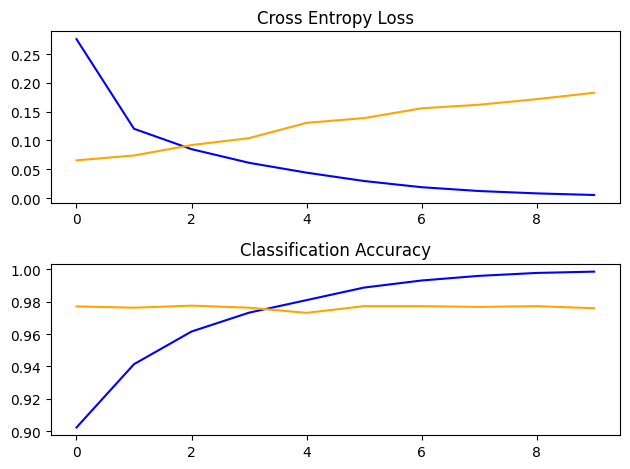

<9112.93 sec> :: Finished Model VGG16


In [13]:
dataset_home = 'data/dataset_dogs_vs_cats/'

def define_model():
	# load model
	model = VGG16(include_top=False, input_shape=(224, 224, 3))
	# mark loaded layers as not trainable
	for layer in model.layers:
		layer.trainable = False
	# add new classifier layers
	flat1 = Flatten()(model.layers[-1].output)
	class1 = Dense(128, activation='relu', kernel_initializer='he_uniform')(flat1)
	output = Dense(1, activation='sigmoid')(class1)
	# define new model
	model = Model(inputs=model.inputs, outputs=output)
	# compile model
	opt = SGD(learning_rate=0.001, momentum=0.9)
	model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
	return model

# run the test harness for evaluating a model
def run_test_harness():
	# define model
	model = define_model()
	# create data generator
	datagen = ImageDataGenerator(featurewise_center=True)
	# specify imagenet mean values for centering
	datagen.mean = [123.68, 116.779, 103.939]
	# prepare iterator
	train_it = datagen.flow_from_directory(f'{dataset_home}/train/',
		class_mode='binary', batch_size=40, target_size=(224, 224))
	test_it = datagen.flow_from_directory(f'{dataset_home}/test/',
		class_mode='binary', batch_size=40, target_size=(224, 224))
	# fit model
	history = model.fit(train_it, steps_per_epoch=len(train_it),
		validation_data=test_it, validation_steps=len(test_it), epochs=10, verbose=1)
	# evaluate model
	_, acc = model.evaluate(test_it, steps=len(test_it), verbose=0)
	print('> %.3f' % (acc * 100.0))
	# learning curves
	summarize_diagnostics(history)


print(f"<{time.time()-start:.2f} sec> :: Start Model VGG16")
# entry point, run the test harness
run_test_harness()
print(f"<{time.time()-start:.2f} sec> :: Finished Model VGG16")

## Task 4
Task: Train your models with networks different from VGG (for example, resnet, rexnet or similar)

### Importing necessary packages

In [14]:
import os
import sys
import tqdm
import time
import shutil
import numpy as np
import random as rnd

from keras import layers
from keras.layers import Dropout, Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D

from keras.models import Model, load_model, Sequential

from keras.preprocessing.image import ImageDataGenerator

from keras.optimizers import SGD
from keras.initializers import glorot_uniform
from keras.utils import plot_model
from IPython.display import SVG

from keras.utils.vis_utils import model_to_dot
import keras.backend as K

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.layers import Concatenate, GlobalAveragePooling2D

### 1. ResNet (Residual Networks)
This model was the winner of the ImageNet challenge in 2015.

In [15]:
ROWS = 224
COLS = 224
CHANNELS = 3
CLASSES = 2

BATCH_SIZE = 32

#### Building a Residual Network:
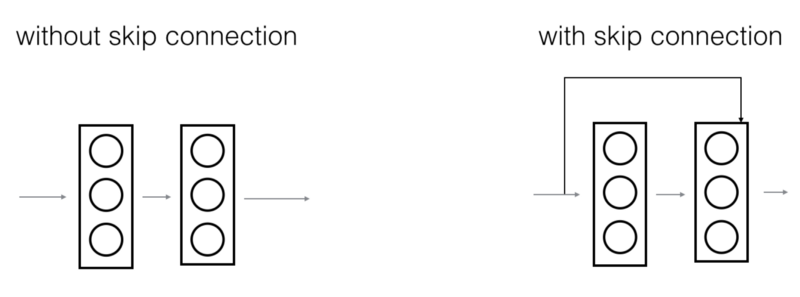

The image above shows the "main path" through the network. The image on the right adds a shortcut to the main path. By stacking these ResNet blocks on top of each other, you can form a very deep network.
Why do Skip Connections work?

- They mitigate the problem of vanishing gradient by allowing this alternate shortcut path for the gradient to flow through;
- They allow the model to learn an identity function which ensures that the higher layer will perform at least as good as the lower layer and not worse.

#### The identity block:

In [16]:
def identity_block(X, f, filters, stage, block):
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    # Retrieve Filters
    F1, F2, F3 = filters

    # Save the input value. We'll need this later to add back to the main path. 
    X_shortcut = X

    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    # Second component of main path
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

#### The convolutional block:

In [17]:
def convolutional_block(X, f, filters, stage, block, s = 2):
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####
    # First component of main path 
    X = Conv2D(F1, (1, 1), strides = (s,s), name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    # Second component of main path
    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    
    ##### SHORTCUT PATH ####
    X_shortcut = Conv2D(F3, (1, 1), strides = (s,s), name = conv_name_base + '1', kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X

#### Building the first ResNet model (50 layers):

In [18]:
def ResNet50(input_shape = (ROWS, COLS, 3), classes = 2):   
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], stage = 2, block='a', s = 1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

    # Stage 3
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], stage = 3, block='a', s = 2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    # Stage 4
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], stage = 4, block='a', s = 2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    # Stage 5
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], stage = 5, block='a', s = 2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    # AVGPOOL.
    X = AveragePooling2D((2, 2), name='avg_pool')(X)

    # output layer
    X = Flatten()(X)

    # If there's 2 classes, only 1 output neuron is needed [class 1 or class 0]
    # if classes == 2: classes=1
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model


#### The model is now ready to be trained

<9113.48 sec> :: Start Model ResNet50
Found 23420 images belonging to 2 classes.
Found 6303 images belonging to 2 classes.
Epoch 1/20
732/732 [==============================] - 172s 228ms/step - loss: 0.9394 - accuracy: 0.5664 - val_loss: 0.7228 - val_accuracy: 0.5477
Epoch 2/20
732/732 [==============================] - 164s 225ms/step - loss: 0.6554 - accuracy: 0.6117 - val_loss: 0.8157 - val_accuracy: 0.5645
Epoch 3/20
732/732 [==============================] - 165s 225ms/step - loss: 0.6160 - accuracy: 0.6471 - val_loss: 0.6769 - val_accuracy: 0.6513
Epoch 4/20
732/732 [==============================] - 165s 225ms/step - loss: 0.6019 - accuracy: 0.6620 - val_loss: 0.7962 - val_accuracy: 0.5656
Epoch 5/20
732/732 [==============================] - 164s 225ms/step - loss: 0.5872 - accuracy: 0.6717 - val_loss: 0.7650 - val_accuracy: 0.6083
Epoch 6/20
732/732 [==============================] - 164s 225ms/step - loss: 0.5639 - accuracy: 0.6960 - val_loss: 0.6737 - val_accuracy: 0.6383
E

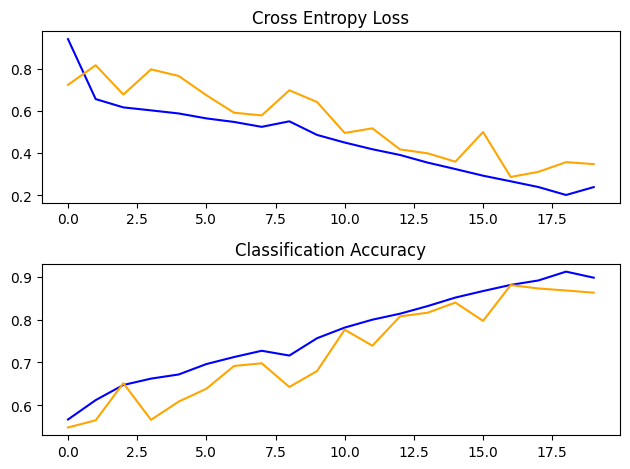

<12425.16 sec> :: Finished Model ResNet50


In [19]:
dataset_home = 'data/dataset_dogs_vs_cats/'
def define_model():
	# load model
	model = ResNet50(input_shape = (ROWS, COLS, CHANNELS), classes = CLASSES)

	# compile model
	model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
	return model

# run the test harness for evaluating a model
def run_test_harness():
	# define model
	model = define_model()
	# create data generator
	datagen = ImageDataGenerator(rescale=1.0/255.0)
	# prepare iterator
	train_it = datagen.flow_from_directory(f'{dataset_home}/train/',
		class_mode='categorical', batch_size=BATCH_SIZE, target_size=(ROWS, COLS))
	test_it = datagen.flow_from_directory(f'{dataset_home}/test/',
		class_mode='categorical', batch_size=BATCH_SIZE, target_size=(ROWS, COLS))
	# fit model
	history = model.fit(train_it, steps_per_epoch=len(train_it),
		validation_data=test_it, validation_steps=len(test_it), epochs=20, verbose=1)
	# evaluate model
	_, acc = model.evaluate(test_it, steps=len(test_it), verbose=0)
	print('> %.3f' % (acc * 100.0))
	# learning curves
	summarize_diagnostics(history)
	return model


print(f"<{time.time()-start:.2f} sec> :: Start Model ResNet50")
# entry point, run the test harness
model = run_test_harness()
print(f"<{time.time()-start:.2f} sec> :: Finished Model ResNet50")

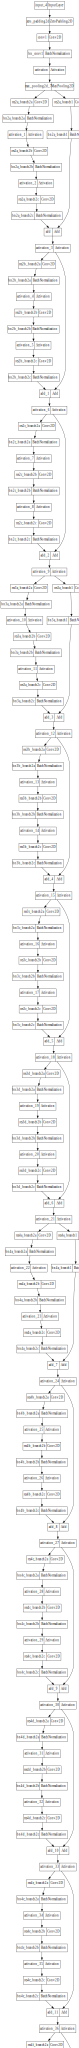

In [20]:
#Opcional
plot_model(model, to_file='outputs/model.png')
SVG(model_to_dot(model).create(prog='dot', format='svg'))

### 2. GoogLeNet
This model was the of the ILSVRC 2014 competition (a.k.a. Inception V1) from Google.

The network used a CNN inspired by LeNet but implemented a novel element which is dubbed an inception module. Is based on several very small convolutions in order to drastically reduce the number of parameters. Their architecture consisted of a 22 layer deep CNN.


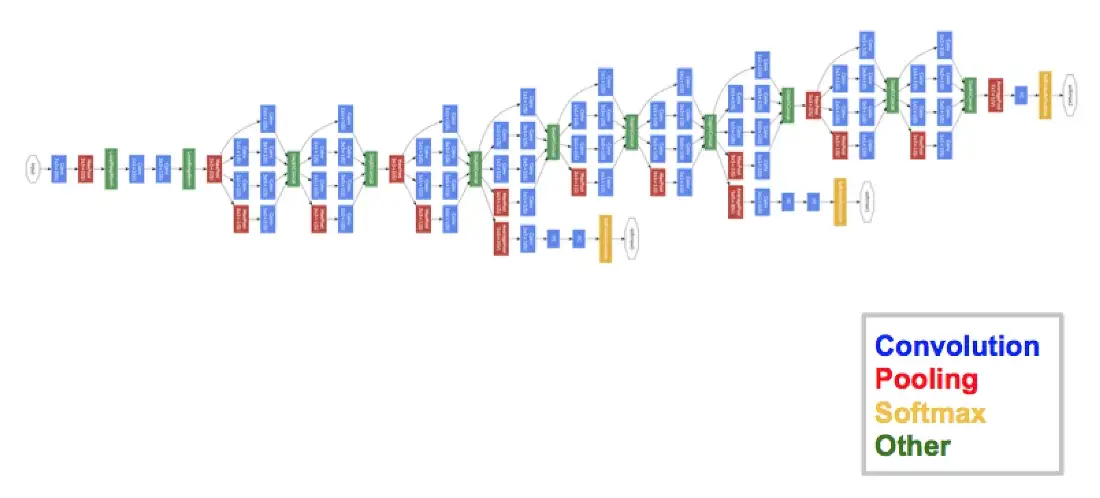

In [21]:
ROWS = 224
COLS = 224
CHANNELS = 3
CLASSES = 2

BATCH_SIZE = 64

In [22]:
from keras.layers.merging.concatenate import concatenate
def Inception_block(input_layer, f1=64, f2_conv1=96, f2_conv3=128, f3_conv1=16, f3_conv5=32, f4=32): 
  # Input: 
  # - f1: number of filters of the 1x1 convolutional layer in the first path
  # - f2_conv1, f2_conv3 are number of filters corresponding to the 1x1 and 3x3 convolutional layers in the second path
  # - f3_conv1, f3_conv5 are the number of filters corresponding to the 1x1 and 5x5  convolutional layer in the third path
  # - f4: number of filters of the 1x1 convolutional layer in the fourth path

  # 1st path:
  path1 = Conv2D(filters=f1, kernel_size = (1,1), padding = 'same', activation = 'relu')(input_layer)

  # 2nd path
  path2 = Conv2D(filters = f2_conv1, kernel_size = (1,1), padding = 'same', activation = 'relu')(input_layer)
  path2 = Conv2D(filters = f2_conv3, kernel_size = (3,3), padding = 'same', activation = 'relu')(path2)

  # 3rd path
  path3 = Conv2D(filters = f3_conv1, kernel_size = (1,1), padding = 'same', activation = 'relu')(input_layer)
  path3 = Conv2D(filters = f3_conv5, kernel_size = (5,5), padding = 'same', activation = 'relu')(path3)

  # 4th path
  path4 = MaxPooling2D((3,3), strides= (1,1), padding = 'same')(input_layer)
  path4 = Conv2D(filters = f4, kernel_size = (1,1), padding = 'same', activation = 'relu')(path4)

  output_layer = concatenate([path1, path2, path3, path4], axis = -1)

  return output_layer


def GoogLeNet(input_shape=(ROWS, COLS, CHANNELS), classes=CLASSES):

  classes = classes if classes!=2 else 1
  # input layer 
  input_layer = Input(input_shape)

  # convolutional layer: filters = 64, kernel_size = (7,7), strides = 2
  X = Conv2D(filters = 64, kernel_size = (7,7), strides = 2, padding = 'valid', activation = 'relu')(input_layer)

  # max-pooling layer: pool_size = (3,3), strides = 2
  X = MaxPooling2D(pool_size = (3,3), strides = 2)(X)

  # convolutional layer: filters = 64, strides = 1
  X = Conv2D(filters = 64, kernel_size = (1,1), strides = 1, padding = 'same', activation = 'relu')(X)

  # convolutional layer: filters = 192, kernel_size = (3,3)
  X = Conv2D(filters = 192, kernel_size = (3,3), padding = 'same', activation = 'relu')(X)

  # max-pooling layer: pool_size = (3,3), strides = 2
  X = MaxPooling2D(pool_size= (3,3), strides = 2)(X)

  # 1st Inception block
  X = Inception_block(X, f1 = 64, f2_conv1 = 96, f2_conv3 = 128, f3_conv1 = 16, f3_conv5 = 32, f4 = 32)

  # 2nd Inception block
  X = Inception_block(X, f1 = 128, f2_conv1 = 128, f2_conv3 = 192, f3_conv1 = 32, f3_conv5 = 96, f4 = 64)

  # max-pooling layer: pool_size = (3,3), strides = 2
  X = MaxPooling2D(pool_size= (3,3), strides = 2)(X)

  # 3rd Inception block
  X = Inception_block(X, f1 = 192, f2_conv1 = 96, f2_conv3 = 208, f3_conv1 = 16, f3_conv5 = 48, f4 = 64)

  # Extra network 1:
  X1 = AveragePooling2D(pool_size = (5,5), strides = 3)(X)
  X1 = Conv2D(filters = 128, kernel_size = (1,1), padding = 'same', activation = 'relu')(X1)
  X1 = Flatten()(X1)
  X1 = Dense(1024, activation = 'relu')(X1)
  X1 = Dropout(0.7)(X1)
  X1 = Dense(5, activation = 'softmax')(X1)

  
  # 4th Inception block
  X = Inception_block(X, f1 = 160, f2_conv1 = 112, f2_conv3 = 224, f3_conv1 = 24, f3_conv5 = 64, f4 = 64)

  # 5th Inception block
  X = Inception_block(X, f1 = 128, f2_conv1 = 128, f2_conv3 = 256, f3_conv1 = 24, f3_conv5 = 64, f4 = 64)

  # 6th Inception block
  X = Inception_block(X, f1 = 112, f2_conv1 = 144, f2_conv3 = 288, f3_conv1 = 32, f3_conv5 = 64, f4 = 64)

  # Extra network 2:
  X2 = AveragePooling2D(pool_size = (5,5), strides = 3)(X)
  X2 = Conv2D(filters = 128, kernel_size = (1,1), padding = 'same', activation = 'relu')(X2)
  X2 = Flatten()(X2)
  X2 = Dense(1024, activation = 'relu')(X2)
  X2 = Dropout(0.7)(X2)
  X2 = Dense(1000, activation = 'softmax')(X2)
  
  
  # 7th Inception block
  X = Inception_block(X, f1 = 256, f2_conv1 = 160, f2_conv3 = 320, f3_conv1 = 32, 
                      f3_conv5 = 128, f4 = 128)

  # max-pooling layer: pool_size = (3,3), strides = 2
  X = MaxPooling2D(pool_size = (3,3), strides = 2)(X)

  # 8th Inception block
  X = Inception_block(X, f1 = 256, f2_conv1 = 160, f2_conv3 = 320, f3_conv1 = 32, f3_conv5 = 128, f4 = 128)

  # 9th Inception block
  X = Inception_block(X, f1 = 384, f2_conv1 = 192, f2_conv3 = 384, f3_conv1 = 48, f3_conv5 = 128, f4 = 128)

  # Global Average pooling layer 
  X = GlobalAveragePooling2D(name = 'GAPL')(X)

  # Dropoutlayer 
  X = Dropout(0.4)(X)

  # output layer 
  X = Dense(classes, activation = 'softmax')(X)
  

  # model
  # model = Model(input_layer, outputs=[X, X1, X2], name = 'GoogLeNet')
  model = Model(input_layer, outputs=X, name = 'GoogLeNet')
  return model

<12426.28 sec> :: Start Model GoogLeNet
Found 23420 images belonging to 2 classes.
Found 6303 images belonging to 2 classes.
Epoch 1/100
366/366 [==============================] - 57s 145ms/step - loss: 0.6931 - accuracy: 0.5024 - val_loss: 0.6930 - val_accuracy: 0.4960
Epoch 2/100
366/366 [==============================] - 50s 136ms/step - loss: 0.6930 - accuracy: 0.5024 - val_loss: 0.6930 - val_accuracy: 0.4960
Epoch 3/100
366/366 [==============================] - 49s 135ms/step - loss: 0.6928 - accuracy: 0.5024 - val_loss: 0.6926 - val_accuracy: 0.4960
Epoch 4/100
366/366 [==============================] - 49s 135ms/step - loss: 0.6925 - accuracy: 0.5024 - val_loss: 0.6921 - val_accuracy: 0.4960
Epoch 5/100
366/366 [==============================] - 49s 135ms/step - loss: 0.6921 - accuracy: 0.5024 - val_loss: 0.6913 - val_accuracy: 0.4960
Epoch 6/100
366/366 [==============================] - 49s 135ms/step - loss: 0.6914 - accuracy: 0.5024 - val_loss: 0.6901 - val_accuracy: 0.4960

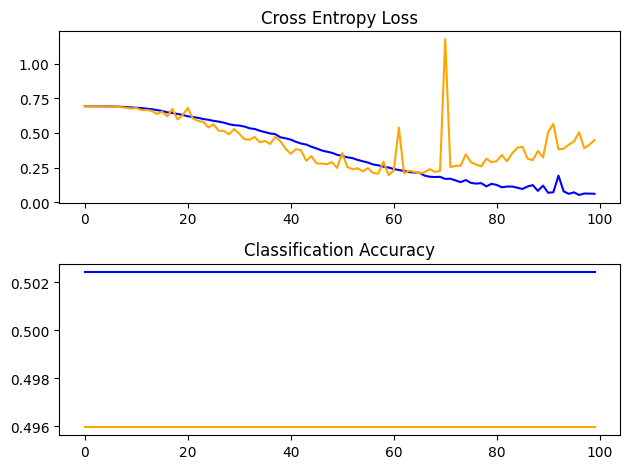

<17376.23 sec> :: Finished Model GoogLeNet


In [23]:
dataset_home = 'data/dataset_dogs_vs_cats/'
def define_model():
    # load model
    model = GoogLeNet(input_shape=(ROWS, COLS, CHANNELS))

    # compile model
    # Learning rate is also a hyperparameter
    opt = SGD(learning_rate=0.01)
    model.compile(loss = "binary_crossentropy", optimizer = opt, metrics=['accuracy'])
    return model

# run the test harness for evaluating a model
def run_test_harness():
	# define model
	model = define_model()
	# create data generator
	datagen = ImageDataGenerator(rescale=1.0/255.0)
	# prepare iterator
	train_it = datagen.flow_from_directory(f'{dataset_home}/train/',
		class_mode='binary', batch_size=BATCH_SIZE, target_size=(ROWS, COLS))
	test_it = datagen.flow_from_directory(f'{dataset_home}/test/',
		class_mode='binary', batch_size=BATCH_SIZE, target_size=(ROWS, COLS))
	# fit model
	history = model.fit(train_it, steps_per_epoch=len(train_it)
                        ,validation_data=test_it, validation_steps=len(test_it)
                        ,epochs=100, verbose=1
                        ,callbacks=[EarlyStopping(patience=5, monitor='loss')]
    )
	# evaluate model
	_, acc = model.evaluate(test_it, steps=len(test_it), verbose=0)
	print('> %.3f' % (acc * 100.0))
	# learning curves
	summarize_diagnostics(history)
	return model



print(f"<{time.time()-start:.2f} sec> :: Start Model GoogLeNet")
# entry point, run the test harness
model = run_test_harness()
print(f"<{time.time()-start:.2f} sec> :: Finished Model GoogLeNet")

## Task 5

Task: Add a new class of animals, for example, pandas (you can create new images using instructions on <a href='https://pyimagesearch.com/2018/04/09/how-to-quickly-build-a-deep-learning-image-dataset/'>this site</a>)


In this section, we're using Microsofts' <a href='https://learn.microsoft.com/en-us/bing/search-apis/bing-image-search/overview'>Bing Image Search API</a> in order to search for photos of "pandas", 
since it's a paid subscription, we limited our search to a maximum of either 900 requests or a maximum number of 7000 different URL's

After obtaining URL's to the 7000 photos, we start downloading them and saving them in the folder "pandas" referenced in [Task 1](#task-1)

### Importing necessary packages


In [24]:
import os
import tqdm
import requests

### Obtaining Photos URL's

In this section, we're using the beforementioned Bing Image Search API to obtain a list of up to 7000 Pandas Photos
We had to write "Pandas Animal" in the query in order to specify our search

It's worth noting that not all photos are of "Pandas" and it's required an overview in order to delete some of the non-interest images in regards to this project

In [25]:
# URL = 'https://api.bing.microsoft.com/v7.0/images/search'
# API_KEY = os.getenv('MICROSOFT_AZURE_API_KEY', '-1')
# MAX_NUM_OF_PHOTOS = 7000
# MAX_NUM_OF_REQUESTS = 900

# assert API_KEY != '-1'

# headers = { 'Ocp-Apim-Subscription-Key': API_KEY }
# params = {
#     'q': 'Panda Animal'     # Search Query [only "Pandas" returned a bunch of data that weren't animal panda]
#     ,'mkt': 'en-US'
#     ,'count': 150
#     ,'offset':1000 
# }

# pbar = tqdm.tqdm(total=MAX_NUM_OF_PHOTOS)

# photos = []

# session = requests.Session()
# response = session.get(URL, headers=headers, params=params)

# photos.extend([x['contentUrl'] for x in response.json()['value']])
# pbar.update(len(photos))
# counter = 1

# while (len(photos)<MAX_NUM_OF_PHOTOS) and (counter<MAX_NUM_OF_REQUESTS):
#     params['offset'] = response.json()['nextOffset']
    
#     response = session.get(URL, headers=headers, params=params)
    
#     photos.extend([x['contentUrl'] for x in response.json()['value']])
#     counter += 1
#     pbar.update(len(photos) - pbar.n)


# photos.extend([x['contentUrl'] for x in response.json()['value']])
# session.close()

# with open('photos_urls.txt', 'w') as f:
#     f.write('\n'.join(photos))

### Downloading Photos

In this section, we're downloading the photos obtained in the previous code block in order to be able to train our model while also storing every URL that we're not able to download due to some error




Despite all our attempts at getting data automatically, the resulting data was barely usable with only +/- 30 "good" different images and the others ~6500 where repetitions of those ~30 images, so we went to <a href='https://www.kaggle.com/datasets/ashishsaxena2209/animal-image-datasetdog-cat-and-panda'>this source</a> in order to get the data

In [26]:
# # Saves image in "URL" to directory "save_file_loc", if a session is given, uses that Session to get the data
# def save_photo(url, save_file_loc, session=None):
#     close = False
#     default_headers = {
#         'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9'
#         ,'User-Agent' : 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/106.0.0.0 Safari/537.36 OPR/92.0.0.0'
#     }

#     if session is None:
#         close = True
#         session = requests.Session()
#     response = session.get(url, headers=default_headers, timeout=5)
#     if response.status_code != 200:
#         if close: session.close()
#         return False
    
#     with open(save_file_loc, 'wb') as f:
#         f.write(response.content)
#     if close: session.close()
#     return True

# # Downloading all Photos
# session = requests.Session()
# error = []
# for (n, url) in tqdm.tqdm(enumerate(photos), total=len(photos), desc='Downloading all photos'):
#     try:
#         if save_photo(url, 'data/pandas/panda.{n}.{file_format}'.format(n=n, file_format=url.split(".")[-1])): continue
#     except:
#         error.append(url)

# session.close()

## Task 6

Task: Train your models again: can you classify well when you add other classes of animals? What if the classes are imbalanced? Does it matter to the humans? Does it matter to the computational models?

In this section, we're going to repeat all the models from [Task 1](#task-1) but with one more class of animals, pandas

### Importing necessary packages

In [14]:
import os
import sys
import tqdm
import time
import shutil
import numpy as np
import random as rnd
import seaborn as sns


from matplotlib import pyplot
from matplotlib.image import imread


from keras.models import Model
from keras.models import Sequential

from keras.optimizers import SGD

from keras.applications.vgg16 import VGG16

from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import MaxPooling2D

from keras.preprocessing.image import ImageDataGenerator


from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score

### Organizing dataset into a useful Structure

In this section, we'll create two new sets of data, one where all the data is balanced (meaning same amount of pictures per animal) and another one with all available labeled data.

Afterwards, the results will be compared

#### Balanced

In [28]:
# create directories
dataset_home = 'data/dataset_balanced_dogs_vs_cats_vs_pandas/'
subdirs = ['train/', 'test/']
for subdir in subdirs:
	# create label subdirectories
	labeldirs = ['dogs/', 'cats/', 'pandas/']
	for labldir in labeldirs:
		newdir = dataset_home + subdir + labldir
		os.makedirs(newdir, exist_ok=True)
# seed random number generator
rnd.seed(1)
# define ratio of pictures to use for validation
val_ratio = 0.25
# copy training dataset images into subdirectories


# List of photos with respective label
# We need the number of animals in each class to be ~ the same to be a "balanced" comparison [this will reduce drastically our dataset]
# So we create a auxiliary variable to help us obtain that value <num_of_animals>
photos = {f'data/cats_and_dogs/train/{x}': 'dogs' for x in os.listdir('data/cats_and_dogs/train/') if 'dog' in x.lower()}
num_of_animals = len(photos.keys())     # initialized to be the number of pictures of dogs
photos.update({f'data/cats_and_dogs/train/{x}': 'cats' for x in os.listdir('data/cats_and_dogs/train/') if 'cat' in x.lower()})
num_of_animals = min(num_of_animals, len(photos.keys())-num_of_animals)   # here the variable is updated to be the minimum between the #dogs and #cats [we're only interested in the minimum]
photos.update({f'data/pandas/{x}': 'pandas' for x in os.listdir('data/pandas/')})
num_of_animals = min(num_of_animals, len(os.listdir('data/pandas/')))    # Here we garantuee the num_of_animals will match the class with the lowest number of records

counter = {'dogs': 0, 'cats': 0, 'pandas': 0}
for photo in tqdm.tqdm(list(photos.keys()), desc='Copying files to new folders'):
	dst_dir = 'train/'
	counter[photos[photo]] += 1
	if counter[photos[photo]] > num_of_animals: continue
	if rnd.random() < val_ratio:
		dst_dir = 'test/'
	shutil.copyfile(photo, dataset_home + dst_dir + photos[photo] + '/' + photo.split("/")[-1])

Copying files to new folders: 100%|██████████| 26035/26035 [00:02<00:00, 10422.34it/s]


#### Imbalanced

In [29]:
# create directories
dataset_home = 'data/dataset_total_dogs_vs_cats_vs_pandas/'
subdirs = ['train/', 'test/']
for subdir in subdirs:
	# create label subdirectories
	labeldirs = ['dogs/', 'cats/', 'pandas/']
	for labldir in labeldirs:
		newdir = dataset_home + subdir + labldir
		os.makedirs(newdir, exist_ok=True)
# seed random number generator
rnd.seed(1)
# define ratio of pictures to use for validation
val_ratio = 0.25
# copy training dataset images into subdirectories

# No need to create the variable again
for photo in tqdm.tqdm(list(photos.keys()), desc='Copying files to new folders'):
	dst_dir = 'train/'
	if rnd.random() < val_ratio:
		dst_dir = 'test/'
	shutil.copyfile(photo, dataset_home + dst_dir + photos[photo] + '/' + photo.split("/")[-1])

Copying files to new folders: 100%|██████████| 26035/26035 [00:20<00:00, 1254.45it/s]


### Modeling the problem

Defining function to draw confusion matrix

In [15]:
def draw_confusion_matrix(Y_true, Y_pred, classes_indices, title='Confusion Matrix'):
	classes_indices = {classes_indices[key]: key for key in classes_indices.keys()}
	# Get and reshape confusion matrix data
	matrix = confusion_matrix(Y_true, Y_pred)

	# Build the plot
	pyplot.figure(figsize=(10,5))
	sns.set(font_scale=1)
	sns.heatmap(matrix, annot=True, annot_kws={'size':10},
				cmap=pyplot.cm.Greens, linewidths=0.2, fmt='g')

	class_names = [classes_indices[i] for i in range(matrix.shape[0])]
	# Add labels to the plot
	tick_marks = np.arange(len(class_names))
	tick_marks2 = tick_marks + 0.5
	pyplot.xticks(tick_marks + 0.5, class_names, rotation=0)
	pyplot.yticks(tick_marks2, class_names, rotation=0)
	pyplot.xlabel('Predicted label')
	pyplot.ylabel('True label')
	pyplot.title(title)
	print("Prediction: {}\nRecall: {}\nF1-score: {}".format(precision_score(Y_true, Y_pred, average='weighted'), recall_score(Y_true, Y_pred, average='weighted'), f1_score(Y_true, Y_pred, average='weighted')))
	pyplot.show()  


def _get_class(arr):
	# Given a lenth 3 array, returns the position of the maximum value (to get class for categorical predictions)
    max_val = 0
    for i in range(len(arr)):
        if arr[i]>arr[max_val]: max_val=i
    return max_val

#### Baseline model

This first model will set the baseline for the next models tested,
- One Block VGG Model 
- converts the images to a (200x200) resolution [it requires images to be all the same resolution]

<1045.51 sec> [balanced] :: Start One Block VGG Model
Found 2342 images belonging to 3 classes.
Found 763 images belonging to 3 classes.
Epoch 1/20
37/37 [==============================] - 8s 210ms/step - loss: 1.0465 - accuracy: 0.4808 - val_loss: 0.7981 - val_accuracy: 0.6134
Epoch 2/20
37/37 [==============================] - 6s 170ms/step - loss: 0.8434 - accuracy: 0.5713 - val_loss: 0.7508 - val_accuracy: 0.6409
Epoch 3/20
37/37 [==============================] - 4s 116ms/step - loss: 0.7648 - accuracy: 0.6260 - val_loss: 0.7512 - val_accuracy: 0.6619
Epoch 4/20
37/37 [==============================] - 4s 119ms/step - loss: 0.7745 - accuracy: 0.6140 - val_loss: 0.7418 - val_accuracy: 0.6448
Epoch 5/20
37/37 [==============================] - 4s 119ms/step - loss: 0.7371 - accuracy: 0.6324 - val_loss: 0.7542 - val_accuracy: 0.6304
Epoch 6/20
37/37 [==============================] - 5s 123ms/step - loss: 0.7090 - accuracy: 0.6657 - val_loss: 0.7275 - val_accuracy: 0.6501
Epoch 7/20


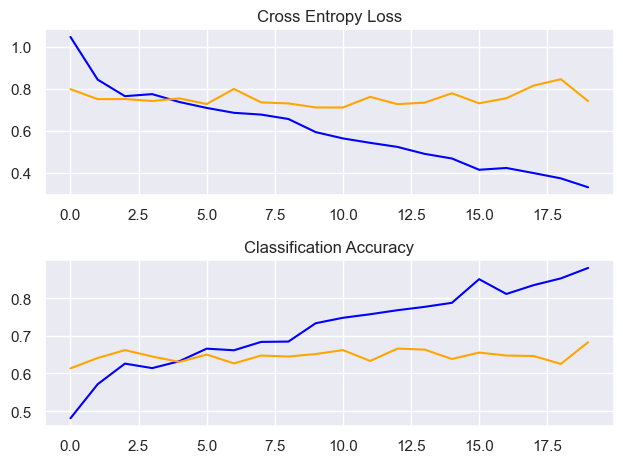

12/12 [==============================] - 1s 92ms/step
Prediction: 0.3273783187386365
Recall: 0.32634338138925295
F1-score: 0.3252446503885628


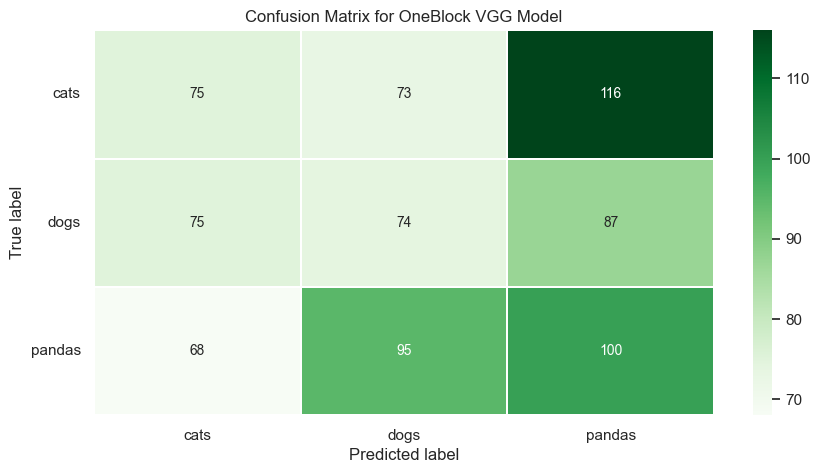

<1144.71 sec> [balanced] :: Finished One Block VGG Model
<1144.71 sec> [total] :: Start One Block VGG Model
Found 19478 images belonging to 3 classes.
Found 6557 images belonging to 3 classes.
Epoch 1/20
305/305 [==============================] - 29s 94ms/step - loss: 0.8865 - accuracy: 0.5491 - val_loss: 0.7414 - val_accuracy: 0.5849
Epoch 2/20
305/305 [==============================] - 28s 91ms/step - loss: 0.7148 - accuracy: 0.6169 - val_loss: 0.7369 - val_accuracy: 0.5983
Epoch 3/20
305/305 [==============================] - 28s 93ms/step - loss: 0.6879 - accuracy: 0.6467 - val_loss: 0.6710 - val_accuracy: 0.6587
Epoch 4/20
305/305 [==============================] - 28s 93ms/step - loss: 0.6454 - accuracy: 0.6798 - val_loss: 0.6770 - val_accuracy: 0.6508
Epoch 5/20
305/305 [==============================] - 28s 93ms/step - loss: 0.6047 - accuracy: 0.7068 - val_loss: 0.6349 - val_accuracy: 0.6800
Epoch 6/20
305/305 [==============================] - 28s 92ms/step - loss: 0.5661 - ac

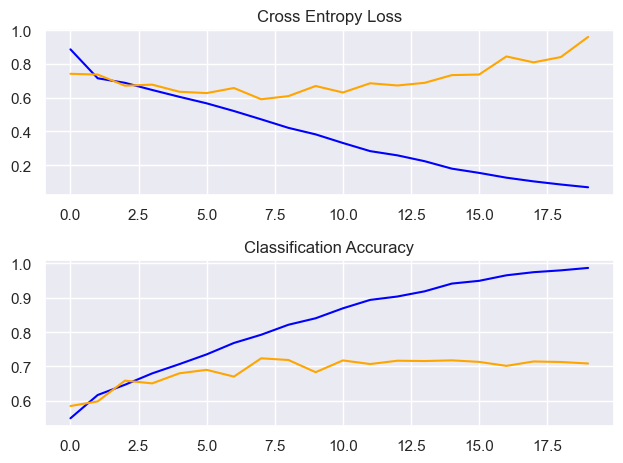

103/103 [==============================] - 7s 68ms/step
Prediction: 0.4646694902363046
Recall: 0.4666768339179503
F1-score: 0.45790248445162524


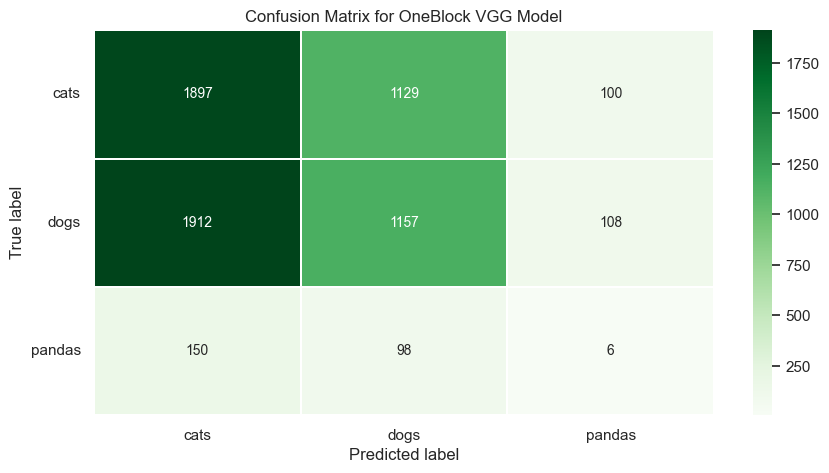

<1746.56 sec> [total] :: Finished One Block VGG Model


In [16]:
for dimension in ['balanced', 'total']:
    dataset_home = f'data/dataset_{dimension}_dogs_vs_cats_vs_pandas/'
    # define cnn model
    def define_model():
        model = Sequential()
        model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(200, 200, 3)))
        model.add(MaxPooling2D((2, 2)))
        model.add(Flatten())
        model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
        # output layer needs to have shape "3" in order to output for each different class
        model.add(Dense(3, activation='softmax'))
        # compile model
        opt = SGD(learning_rate=0.001, momentum=0.9)
        model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
        return model

    # run the test harness for evaluating a model
    def run_test_harness():
        # define model
        model = define_model()
        # create data generator
        datagen = ImageDataGenerator(rescale=1.0/255.0)
        # prepare iterators
        train_it = datagen.flow_from_directory(f'{dataset_home}/train/',
            class_mode='categorical', batch_size=64, target_size=(200, 200))
        test_it = datagen.flow_from_directory(f'{dataset_home}/test/',
            class_mode='categorical', batch_size=64, target_size=(200, 200))
        # fit model
        history = model.fit(train_it, steps_per_epoch=len(train_it),
            validation_data=test_it, validation_steps=len(test_it), epochs=20, verbose=1)
        # evaluate model
        _, acc = model.evaluate(test_it, steps=len(test_it), verbose=0)
        print('> %.3f' % (acc * 100.0))
        # learning curves
        summarize_diagnostics(history)

        # Drawing confusion Matrix
        Y_pred = [_get_class(y) for y in model.predict(test_it)]
        y_test = [test_it[i][1] for i in range(len(test_it))]
        y_test = [_get_class(y) for i in y_test for y in i]
        draw_confusion_matrix(y_test, Y_pred, test_it.class_indices, title='Confusion Matrix for OneBlock VGG Model')

    print(f"<{time.time()-start:.2f} sec> [{dimension}] :: Start One Block VGG Model")
    # entry point, run the test harness 
    run_test_harness()
    print(f"<{time.time()-start:.2f} sec> [{dimension}] :: Finished One Block VGG Model")

#### Baseline model with data augmentation

This first model will set the baseline for the next models tested,
- Three Block VGG Model 
- Data augmentation with "horizontal_flip" + "width" + "Height" shift
- converts the images to a (200x200) resolution [it requires images to be all the same resolution]

<1746.62 sec> [balanced] :: Start One Block VGG Model
Found 2342 images belonging to 3 classes.
Found 763 images belonging to 3 classes.
Epoch 1/20
37/37 [==============================] - 22s 433ms/step - loss: 1.1424 - accuracy: 0.4295 - val_loss: 0.9312 - val_accuracy: 0.5491
Epoch 2/20
37/37 [==============================] - 14s 385ms/step - loss: 0.9015 - accuracy: 0.5482 - val_loss: 0.7822 - val_accuracy: 0.6186
Epoch 3/20
37/37 [==============================] - 14s 386ms/step - loss: 0.8420 - accuracy: 0.5820 - val_loss: 0.7764 - val_accuracy: 0.6055
Epoch 4/20
37/37 [==============================] - 14s 385ms/step - loss: 0.8205 - accuracy: 0.5944 - val_loss: 0.9127 - val_accuracy: 0.5059
Epoch 5/20
37/37 [==============================] - 14s 386ms/step - loss: 0.8269 - accuracy: 0.5798 - val_loss: 0.8741 - val_accuracy: 0.5727
Epoch 6/20
37/37 [==============================] - 14s 387ms/step - loss: 0.7969 - accuracy: 0.5974 - val_loss: 0.7219 - val_accuracy: 0.6750
Epoch

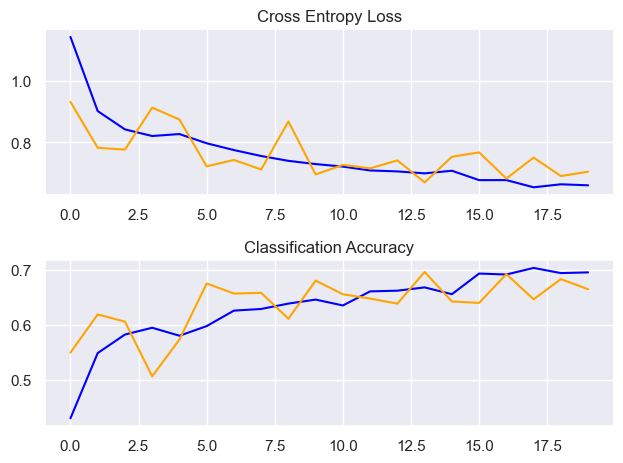

12/12 [==============================] - 1s 88ms/step
Prediction: 0.31478482238412386
Recall: 0.30930537352555704
F1-score: 0.29034182375675016


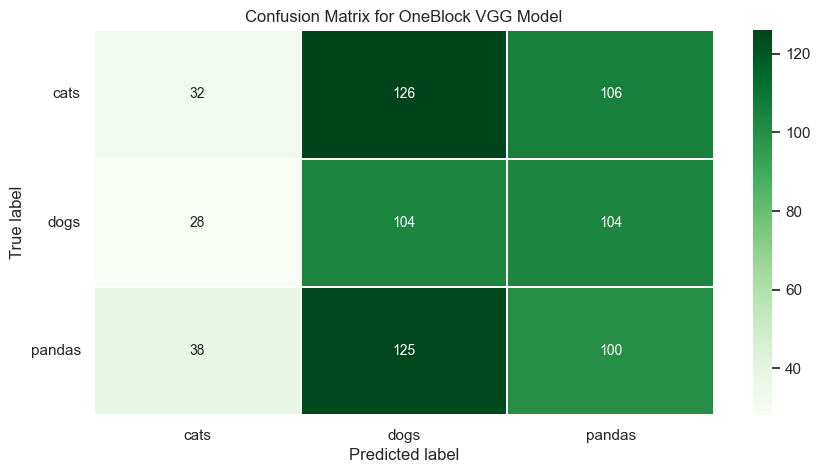

<2046.36 sec> [balanced] :: Finished One Block VGG Model
<2046.36 sec> [total] :: Start One Block VGG Model
Found 19478 images belonging to 3 classes.
Found 6557 images belonging to 3 classes.
Epoch 1/20
305/305 [==============================] - 113s 369ms/step - loss: 0.8597 - accuracy: 0.5583 - val_loss: 0.7281 - val_accuracy: 0.6015
Epoch 2/20
305/305 [==============================] - 112s 367ms/step - loss: 0.7142 - accuracy: 0.6192 - val_loss: 0.7202 - val_accuracy: 0.6575
Epoch 3/20
305/305 [==============================] - 111s 365ms/step - loss: 0.6789 - accuracy: 0.6565 - val_loss: 0.6271 - val_accuracy: 0.6976
Epoch 4/20
305/305 [==============================] - 111s 365ms/step - loss: 0.6515 - accuracy: 0.6752 - val_loss: 0.6142 - val_accuracy: 0.7174
Epoch 5/20
305/305 [==============================] - 112s 367ms/step - loss: 0.6227 - accuracy: 0.7027 - val_loss: 0.6056 - val_accuracy: 0.7214
Epoch 6/20
305/305 [==============================] - 112s 366ms/step - loss:

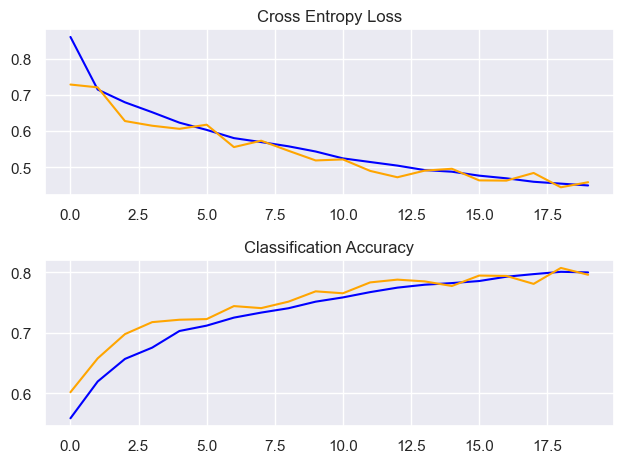

103/103 [==============================] - 13s 126ms/step
Prediction: 0.46407667622411164
Recall: 0.46179655330181485
F1-score: 0.4590184422946225


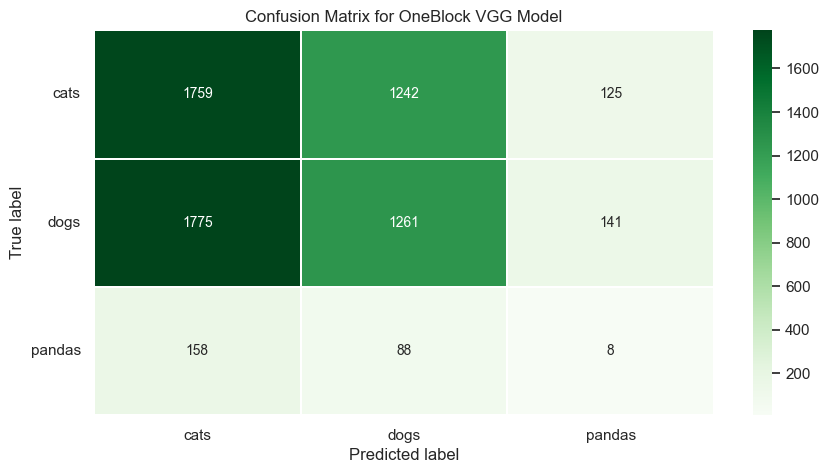

<4338.88 sec> [total] :: Finished One Block VGG Model


In [17]:
for dimension in ['balanced', 'total']:
	dataset_home = f'data/dataset_{dimension}_dogs_vs_cats_vs_pandas/'
		
	# define cnn model
	def define_model():
		model = Sequential()
		model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(200, 200, 3)))
		model.add(MaxPooling2D((2, 2)))
		model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
		model.add(MaxPooling2D((2, 2)))
		model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
		model.add(MaxPooling2D((2, 2)))
		model.add(Flatten())
		model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
		# output layer needs to have shape "3" in order to output for each different class
		model.add(Dense(3, activation='softmax'))
		# compile model
		opt = SGD(learning_rate=0.001, momentum=0.9)
		model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
		return model

	# run the test harness for evaluating a model
	def run_test_harness():
		# define model
		model = define_model()
		# create data generators
		train_datagen = ImageDataGenerator(rescale=1.0/255.0,
			width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
		test_datagen = ImageDataGenerator(rescale=1.0/255.0)
		# prepare iterators
		train_it = train_datagen.flow_from_directory(f'{dataset_home}/train/',
			class_mode='categorical', batch_size=64, target_size=(200, 200))
		test_it = test_datagen.flow_from_directory(f'{dataset_home}/test/',
			class_mode='categorical', batch_size=64, target_size=(200, 200))
		# fit model
		history = model.fit(train_it, steps_per_epoch=len(train_it),
			validation_data=test_it, validation_steps=len(test_it), epochs=20, verbose=1)
		# evaluate model
		_, acc = model.evaluate(test_it, steps=len(test_it), verbose=0)
		print('> %.3f' % (acc * 100.0))
		# learning curves
		summarize_diagnostics(history)

		# Drawing confusion Matrix
		Y_pred = [_get_class(y) for y in model.predict(test_it)]
		y_test = [test_it[i][1] for i in range(len(test_it))]
		y_test = [_get_class(y) for i in y_test for y in i]
		draw_confusion_matrix(y_test, Y_pred, test_it.class_indices, title='Confusion Matrix for OneBlock VGG Model')

	print(f"<{time.time()-start:.2f} sec> [{dimension}] :: Start One Block VGG Model")
	# entry point, run the test harness
	run_test_harness()
	print(f"<{time.time()-start:.2f} sec> [{dimension}] :: Finished One Block VGG Model")

#### Baseline model with dropout regularization

This first model will set the baseline for the next models tested,
- Three Block VGG Model 
- Each block has a dropout regularization of 20% and a dropout rate of 50% applied after the fully connected layer in the classifier part of the model
- converts the images to a (200x200) resolution [it requires images to be all the same resolution]

<4338.96 sec> [balanced] :: Start Three Blocks VGG with Dropout
Found 2342 images belonging to 3 classes.
Found 763 images belonging to 3 classes.
Epoch 1/20
37/37 [==============================] - 12s 314ms/step - loss: 2.0914 - accuracy: 0.3689 - val_loss: 1.0776 - val_accuracy: 0.3604
Epoch 2/20
37/37 [==============================] - 5s 125ms/step - loss: 1.0405 - accuracy: 0.4330 - val_loss: 1.0490 - val_accuracy: 0.4744
Epoch 3/20
37/37 [==============================] - 5s 124ms/step - loss: 0.9663 - accuracy: 0.4898 - val_loss: 1.0325 - val_accuracy: 0.4640
Epoch 4/20
37/37 [==============================] - 5s 124ms/step - loss: 0.9366 - accuracy: 0.5141 - val_loss: 1.0301 - val_accuracy: 0.4299
Epoch 5/20
37/37 [==============================] - 5s 127ms/step - loss: 0.9288 - accuracy: 0.5196 - val_loss: 1.1044 - val_accuracy: 0.3709
Epoch 6/20
37/37 [==============================] - 5s 127ms/step - loss: 0.9001 - accuracy: 0.5201 - val_loss: 1.0441 - val_accuracy: 0.4181


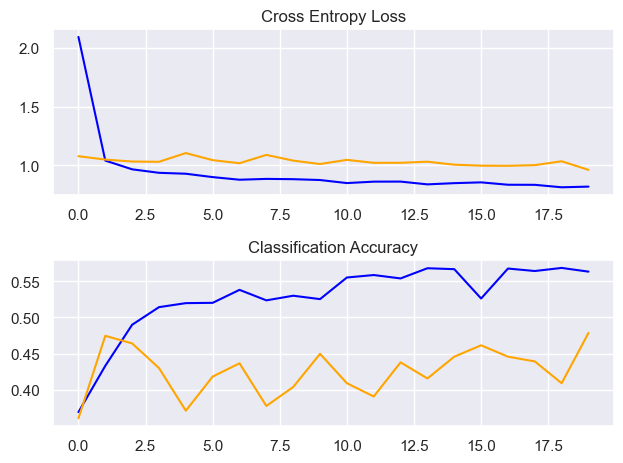

12/12 [==============================] - 1s 90ms/step
Prediction: 0.29174474862960637
Recall: 0.3224115334207077
F1-score: 0.2656505608970034


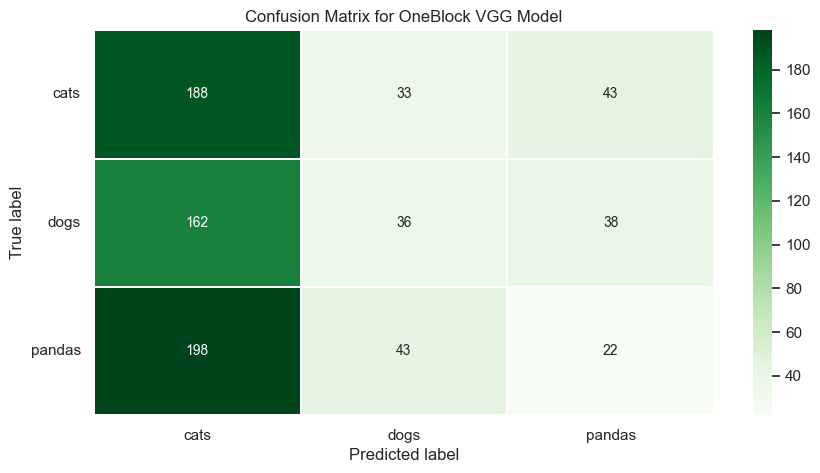

<4445.91 sec> [balanced] :: Finished Three Blocks VGG with Dropout
<4445.91 sec> [total] :: Start Three Blocks VGG with Dropout
Found 19478 images belonging to 3 classes.
Found 6557 images belonging to 3 classes.
Epoch 1/20
305/305 [==============================] - 33s 108ms/step - loss: 1.0143 - accuracy: 0.5009 - val_loss: 0.8087 - val_accuracy: 0.5173
Epoch 2/20
305/305 [==============================] - 32s 104ms/step - loss: 0.7895 - accuracy: 0.5257 - val_loss: 0.7636 - val_accuracy: 0.5716
Epoch 3/20
305/305 [==============================] - 34s 110ms/step - loss: 0.7600 - accuracy: 0.5554 - val_loss: 0.7476 - val_accuracy: 0.5957
Epoch 4/20
305/305 [==============================] - 33s 109ms/step - loss: 0.7372 - accuracy: 0.5790 - val_loss: 0.7257 - val_accuracy: 0.5879
Epoch 5/20
305/305 [==============================] - 32s 104ms/step - loss: 0.7235 - accuracy: 0.5973 - val_loss: 0.7160 - val_accuracy: 0.6384
Epoch 6/20
305/305 [==============================] - 33s 109m

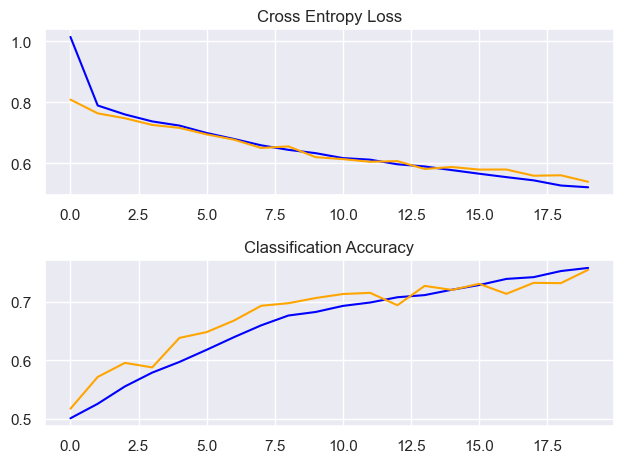

103/103 [==============================] - 7s 66ms/step
Prediction: 0.4719830970592771
Recall: 0.47399725484215344
F1-score: 0.4712506668176566


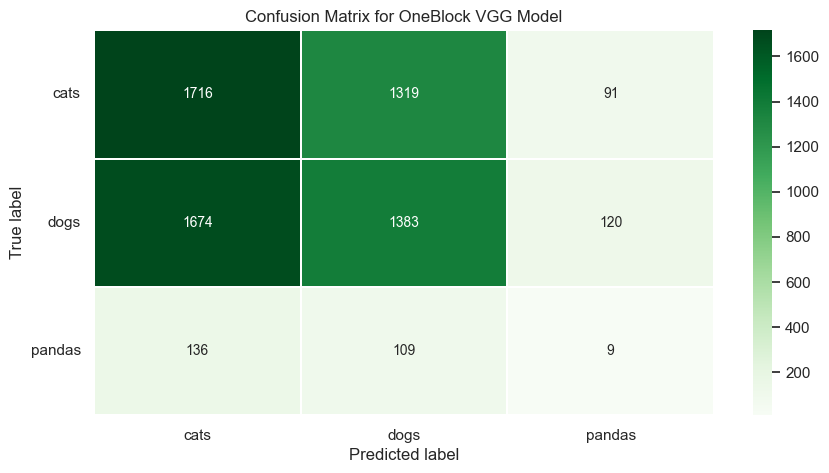

<5112.58 sec> [total] :: Finished Three Blocks VGG with Dropout


In [18]:
for dimension in ['balanced', 'total']:
	dataset_home = f'data/dataset_{dimension}_dogs_vs_cats_vs_pandas/'

	# define cnn model
	def define_model():
		model = Sequential()
		model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(200, 200, 3)))
		model.add(MaxPooling2D((2, 2)))
		model.add(Dropout(0.2))
		model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
		model.add(MaxPooling2D((2, 2)))
		model.add(Dropout(0.2))
		model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
		model.add(MaxPooling2D((2, 2)))
		model.add(Dropout(0.2))
		model.add(Flatten())
		model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
		model.add(Dropout(0.5))
		# output layer needs to have shape "3" in order to output for each different class
		model.add(Dense(3, activation='softmax'))
		# compile model
		opt = SGD(learning_rate=0.001, momentum=0.9)
		model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
		return model

	# run the test harness for evaluating a model
	def run_test_harness():
		# define model
		model = define_model()
		# create data generator
		datagen = ImageDataGenerator(rescale=1.0/255.0)
		# prepare iterator
		train_it = datagen.flow_from_directory(f'{dataset_home}/train/',
			class_mode='categorical', batch_size=64, target_size=(200, 200))
		test_it = datagen.flow_from_directory(f'{dataset_home}/test/',
			class_mode='categorical', batch_size=64, target_size=(200, 200))
		# fit model
		history = model.fit(train_it, steps_per_epoch=len(train_it),
			validation_data=test_it, validation_steps=len(test_it), epochs=20, verbose=1)
		# evaluate model
		_, acc = model.evaluate(test_it, steps=len(test_it), verbose=0)
		print('> %.3f' % (acc * 100.0))
		# learning curves
		summarize_diagnostics(history)

		# Drawing confusion Matrix
		Y_pred = [_get_class(y) for y in model.predict(test_it)]
		y_test = [test_it[i][1] for i in range(len(test_it))]
		y_test = [_get_class(y) for i in y_test for y in i]
		draw_confusion_matrix(y_test, Y_pred, test_it.class_indices, title='Confusion Matrix for OneBlock VGG Model')


	print(f"<{time.time()-start:.2f} sec> [{dimension}] :: Start Three Blocks VGG with Dropout")
	# entry point, run the test harness
	run_test_harness()
	print(f"<{time.time()-start:.2f} sec> [{dimension}] :: Finished Three Blocks VGG with Dropout")

#### VGG16 Model    

In this example it is explored a different model, VGG16, which is divided into 2 parts:
- The feature extractor part of the model that is made up of VGG blocks
- The classifier part of the model that is made up of fully connected layers and the output layer

With this model, it is expected an image shape of 244x244 pixels and it's necessary to explicitly mension the mean pixel values, which were obtained at the tutorial of this Task.

<5112.65 sec> [balanced] :: Start Model VGG16
Found 2342 images belonging to 3 classes.
Found 763 images belonging to 3 classes.
Epoch 1/10
37/37 [==============================] - 31s 501ms/step - loss: 2.1792 - accuracy: 0.8980 - val_loss: 0.8400 - val_accuracy: 0.9305
Epoch 2/10
37/37 [==============================] - 9s 232ms/step - loss: 0.1007 - accuracy: 0.9787 - val_loss: 0.3814 - val_accuracy: 0.9712
Epoch 3/10
37/37 [==============================] - 9s 232ms/step - loss: 0.0123 - accuracy: 0.9962 - val_loss: 0.3543 - val_accuracy: 0.9725
Epoch 4/10
37/37 [==============================] - 9s 233ms/step - loss: 0.0017 - accuracy: 0.9996 - val_loss: 0.3605 - val_accuracy: 0.9712
Epoch 5/10
37/37 [==============================] - 9s 232ms/step - loss: 5.9546e-04 - accuracy: 1.0000 - val_loss: 0.3673 - val_accuracy: 0.9712
Epoch 6/10
37/37 [==============================] - 9s 232ms/step - loss: 4.4219e-04 - accuracy: 1.0000 - val_loss: 0.3715 - val_accuracy: 0.9712
Epoch 7/10

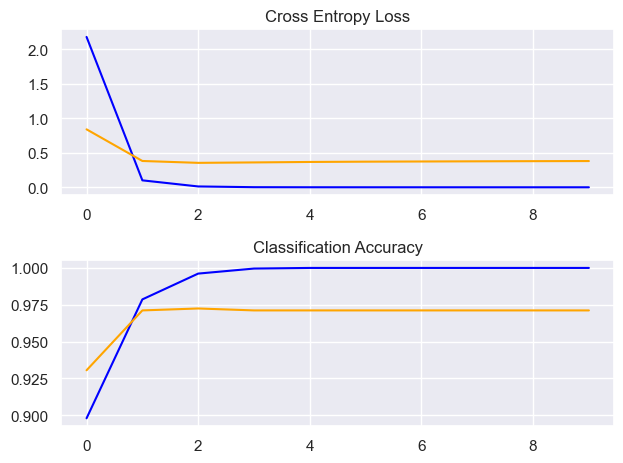

12/12 [==============================] - 2s 182ms/step
Prediction: 0.3143608180926839
Recall: 0.3145478374836173
F1-score: 0.3144470773521224


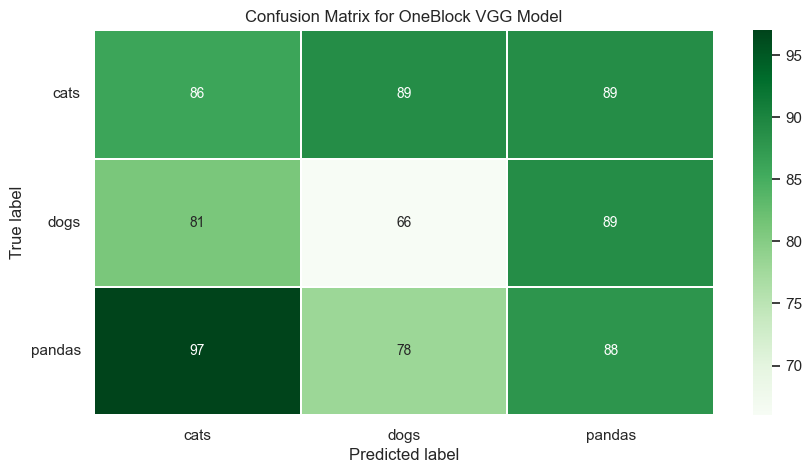

<5228.89 sec> [balanced] :: Finished Model VGG16
<5228.89 sec> [total] :: Start Model VGG16
Found 19478 images belonging to 3 classes.
Found 6557 images belonging to 3 classes.
Epoch 1/10
305/305 [==============================] - 78s 252ms/step - loss: 1.0928 - accuracy: 0.9529 - val_loss: 0.0831 - val_accuracy: 0.9736
Epoch 2/10
305/305 [==============================] - 71s 231ms/step - loss: 0.0476 - accuracy: 0.9832 - val_loss: 0.0756 - val_accuracy: 0.9767
Epoch 3/10
305/305 [==============================] - 71s 234ms/step - loss: 0.0204 - accuracy: 0.9922 - val_loss: 0.0951 - val_accuracy: 0.9767
Epoch 4/10
305/305 [==============================] - 72s 237ms/step - loss: 0.0085 - accuracy: 0.9968 - val_loss: 0.1100 - val_accuracy: 0.9782
Epoch 5/10
305/305 [==============================] - 73s 238ms/step - loss: 0.0043 - accuracy: 0.9985 - val_loss: 0.1202 - val_accuracy: 0.9782
Epoch 6/10
305/305 [==============================] - 72s 236ms/step - loss: 0.0031 - accuracy: 0.

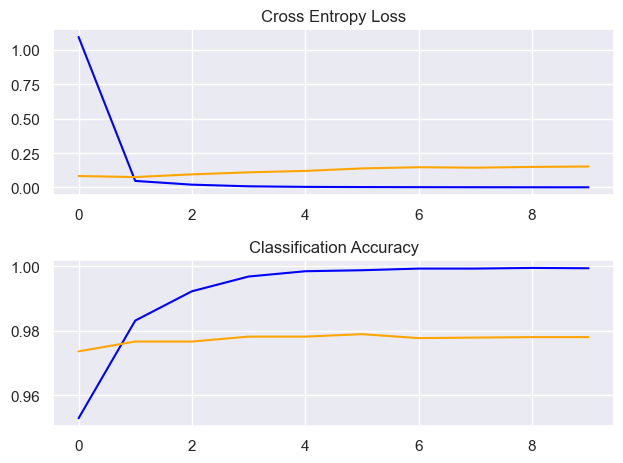

103/103 [==============================] - 18s 171ms/step
Prediction: 0.4527657337642537
Recall: 0.4535610797620863
F1-score: 0.45316153563765404


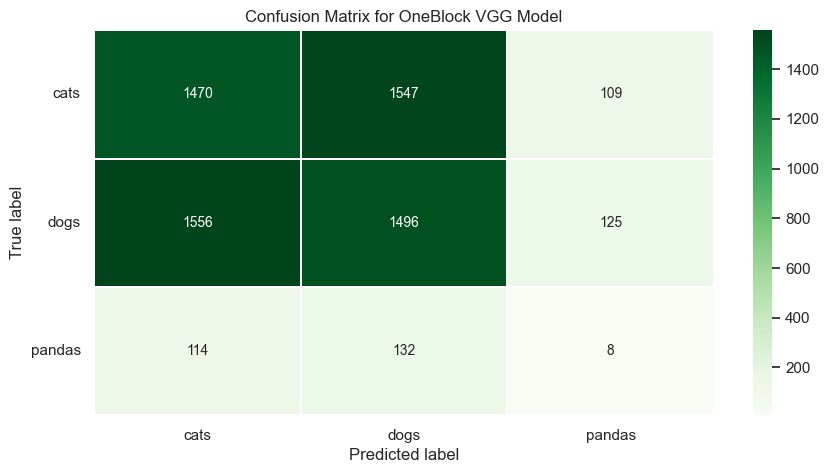

<5995.00 sec> [total] :: Finished Model VGG16


In [19]:
for dimension in ['balanced', 'total']:
	dataset_home = f'data/dataset_{dimension}_dogs_vs_cats_vs_pandas/'

	def define_model():
		# load model
		model = VGG16(include_top=False, input_shape=(224, 224, 3))
		# mark loaded layers as not trainable
		for layer in model.layers:
			layer.trainable = False
		# add new classifier layers
		flat1 = Flatten()(model.layers[-1].output)
		class1 = Dense(128, activation='relu', kernel_initializer='he_uniform')(flat1)
		output = Dense(3, activation='softmax')(class1)	 # output layer needs to have shape "3" in order to output for each different class
		# define new model
		model = Model(inputs=model.inputs, outputs=output)
		# compile model
		opt = SGD(learning_rate=0.001, momentum=0.9)
		model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
		return model

	# run the test harness for evaluating a model
	def run_test_harness():
		# define model
		model = define_model()
		# create data generator
		datagen = ImageDataGenerator(featurewise_center=True)
		# specify imagenet mean values for centering
		datagen.mean = [123.68, 116.779, 103.939]
		# prepare iterator
		train_it = datagen.flow_from_directory(f'{dataset_home}/train/',
			class_mode='categorical', batch_size=64, target_size=(224, 224))
		test_it = datagen.flow_from_directory(f'{dataset_home}/test/',
			class_mode='categorical', batch_size=64, target_size=(224, 224))
		# fit model
		history = model.fit(train_it, steps_per_epoch=len(train_it),
			validation_data=test_it, validation_steps=len(test_it), epochs=10, verbose=1)
		# evaluate model
		_, acc = model.evaluate(test_it, steps=len(test_it), verbose=0)
		print('> %.3f' % (acc * 100.0))
		# learning curves
		summarize_diagnostics(history)
		
		# Drawing confusion Matrix
		Y_pred = [_get_class(y) for y in model.predict(test_it)]
		y_test = [test_it[i][1] for i in range(len(test_it))]
		y_test = [_get_class(y) for i in y_test for y in i]
		draw_confusion_matrix(y_test, Y_pred, test_it.class_indices, title='Confusion Matrix for OneBlock VGG Model')


	print(f"<{time.time()-start:.2f} sec> [{dimension}] :: Start Model VGG16")
	# entry point, run the test harness
	run_test_harness()
	print(f"<{time.time()-start:.2f} sec> [{dimension}] :: Finished Model VGG16")

## Task 7

Task: Another way of training is using a description of the images (a very simple way of doing it is shown <a href='https://medium.com/@TheGeekiestOne/how-to-teach-a-computer-to-distinguish-cats-from-dogs-d66cc0679287'>here</a>, but you can also fecth images and image metadata from <a href='https://medium.com/@TheGeekiestOne/how-to-teach-a-computer-to-distinguish-cats-from-dogs-d66cc0679287'>this kaggle competition</a>)

### Importing necessary packages

In [34]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import random as rnd
import pandas as pd
import tqdm

from keras.layers import Dense, Input
from keras.optimizers import SGD

from keras.models import load_model

from keras.utils import image_dataset_from_directory

import cv2


import os
import numpy as np


from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

### Labeling each picture with previous obtained model

Since the pictures given in this dataset don't have labels, we're using the previously obtained model to label this dataset and by hand-checking it afterwards [to reduce labor work]

In [35]:
def load_image(im_dir):
    im = cv2.imread(im_dir)
    im = im/255
    return cv2.resize(im, (224, 224))


def draw_confusion_matrix(Y_test, Y_pred):
    # Get and reshape confusion matrix data
    matrix = confusion_matrix(Y_test, Y_pred)

    # Build the plot
    pyplot.figure(figsize=(10,5))
    sns.set(font_scale=1)
    sns.heatmap(matrix, annot=True, annot_kws={'size':10},
                cmap=pyplot.cm.Greens, linewidths=0.2, fmt='g')

    class_names = [i for i in range(matrix.shape[0])]
    # Add labels to the plot
    tick_marks = np.arange(len(class_names))
    tick_marks2 = tick_marks + 0.5
    pyplot.xticks(tick_marks + 0.5, class_names, rotation=0)
    pyplot.yticks(tick_marks2, class_names, rotation=0)
    pyplot.xlabel('Predicted label')
    pyplot.ylabel('True label')
    pyplot.title('Confusion Matrix for Random Forest Model')
    pyplot.show()

In [36]:
BATCH_SIZE = 32
ROWS = 224
COLS = 224

dataset_home = 'data/cats_and_dogs_features'
model = load_model('final_model.h5')

train_data = pd.read_csv(f'{dataset_home}/train.csv', sep=',', encoding='utf-8')
labels = []
for n in tqdm.trange(train_data.shape[0]//BATCH_SIZE + 1):
    images = np.array([load_image(f'{dataset_home}/train/{row["Id"]}.jpg') for _, row in train_data.iloc[n*BATCH_SIZE:(n+1)*BATCH_SIZE].iterrows()])
    labels.extend(model.predict(images, batch_size=BATCH_SIZE,verbose=0).T.tolist()[0])

train_data['label'] = labels
train_data['label'] = train_data['label'].round()

n_cats = train_data[train_data['label']==0].shape[0]
n_dogs = train_data.shape[0] - n_cats

print(f"Identified {n_cats} ({n_cats/(train_data.shape[0])*100:.2f}%) cats and {n_dogs} ({n_dogs/(train_data.shape[0])*100:.2f}%) dogs".format())
aux = train_data.set_index('Id').to_dict(orient='index')
for photo in tqdm.tqdm(list(aux.keys())):
    src = f'{dataset_home}/train'
    dst = f'{dataset_home}/labeled_dogs_and_cats'
    # shutil.copy(f'{src}\\{photo}.jpg', f'{dst}\\{aux[photo]["label"]:.0f}\\{photo}.jpg')

100%|██████████| 310/310 [02:38<00:00,  1.95it/s]


Identified 9855 (99.42%) cats and 57 (0.58%) dogs


100%|██████████| 9912/9912 [00:00<00:00, 3308183.44it/s]


#### Fine-tuning the model decision

Since the model made some mistakes (by some, we mean A LOT) we needed to correct some of the mislabeling done, and after that, we got a dataset consisting of +/-730 dogs and cats (more or less balanced)

With this new "organized" dataset, we're able to model the problem with the correct labeling

##### Dropping data deleted

In [37]:
train_data['drop'] = True
train_data.loc[train_data['Id'].isin([x.replace('.jpg', '') for x in list(os.listdir(f'{dataset_home}/labeled_dogs_and_cats/0'))]), 'drop'] = False
train_data.loc[train_data['Id'].isin([x.replace('.jpg', '') for x in list(os.listdir(f'{dataset_home}/labeled_dogs_and_cats/1'))]), 'drop'] = False

# Drop unlabeled data
train_data = train_data[~train_data['drop']]
train_data = train_data.drop(columns = ['drop', 'Pawpularity'])

##### Correcting the labels

Since some of the images were incorrectly labeled, it's needed to correct them.

Seeing as we manually moved the images to each respective folder, it's easier to do it this way

In [38]:
train_data.loc[train_data['Id'].isin(list(os.listdir(f'{dataset_home}/labeled_dogs_and_cats/0'))), 'label'] = 0
train_data.loc[train_data['Id'].isin(list(os.listdir(f'{dataset_home}/labeled_dogs_and_cats/1'))), 'label'] = 1

### Dividing the dataset into training and testing

Now that we've "cleaned up" the data, we are able to divide it into 2 different sets, training and testing

Since there's a lack of data, we're going to be distribuiting it by 90% training, 10% testing

In [39]:
# seed random number generator
rnd.seed(1)
# define ratio of pictures to use for validation
val_ratio = 0.1

# Building testing set from training in order to calculate loss
test_data = pd.DataFrame(columns = train_data.columns)
for (index, row) in train_data.iterrows():
    if rnd.random() < val_ratio:
        test_data.loc[len(test_data)] = row
        train_data.drop(index, axis=0, inplace=True)



X_train = train_data[train_data.columns[1:-1]].to_numpy().astype('float64')
Y_train = train_data[train_data.columns[-1]].to_numpy().astype('float64')

X_test = test_data[test_data.columns[1:-1]].to_numpy().astype('float64')
Y_test = test_data[test_data.columns[-1]].to_numpy().astype('float64')

print(f'Train set size: {train_data.shape[0]} ({train_data.shape[0]/(train_data.shape[0] + test_data.shape[0])*100:.2f}%)\nTest set size: {test_data.shape[0]} ({test_data.shape[0]/(train_data.shape[0] + test_data.shape[0])*100:.2f}%)')

Train set size: 663 (89.72%)
Test set size: 76 (10.28%)


### Modeling the Problem

In this section we explore some different models to predict the values of "Pawpularity"

#### Random Forests

<26680.27 sec> :: Start Random Forests Model
> 84.211


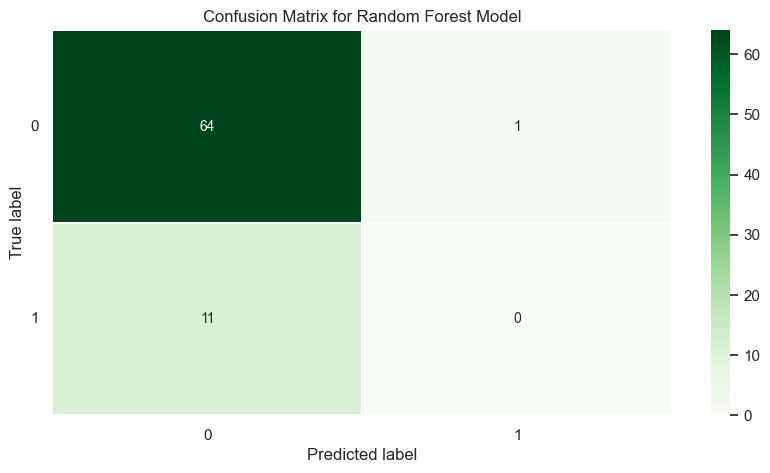

<26680.48 sec> :: Finished Random Forests Model


In [40]:
# run the test harness for evaluating a model
def run_test_harness():
    # define model
    model = RandomForestRegressor(max_depth=5)
    # fit model
    history = model.fit(X_train, Y_train)
    # evaluate model
    Y_pred = model.predict(X_test).round()

    acc = accuracy_score(Y_test, Y_pred)
    print('> %.3f' % (acc * 100.0))

    draw_confusion_matrix(Y_test, Y_pred, {0: 0, 1:1}, title='Confusion Matrix for OneBlock VGG Model')
    
    return model


print(f"<{time.time()-start:.2f} sec> :: Start Random Forests Model")
# entry point, run the test harness
model = run_test_harness()
print(f"<{time.time()-start:.2f} sec> :: Finished Random Forests Model")

#### Using Neural Networks

We defined a simple model with 4 hidden layers

<26680.52 sec> :: Start Simple NN Model
3/3 [==============================] - 0s 2ms/step
> 85.526


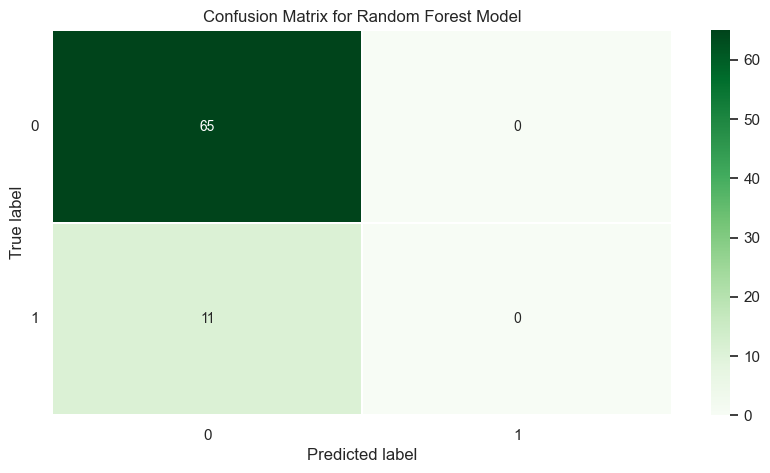

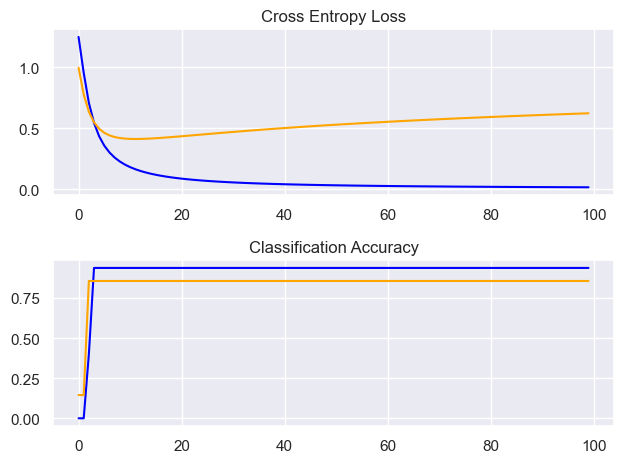

<26692.91 sec> :: Finished Simple NN Model


In [41]:
def define_model():
    model = Sequential()
    model.add(Input(shape=(12,)))
    model.add(Dense(12, activation='relu'))
    model.add(Dense(6, activation='relu'))
    model.add(Dense(4, activation='sigmoid'))
    model.add(Dense(2, activation='sigmoid'))
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    opt = SGD(learning_rate=0.002, momentum=0.9)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# run the test harness for evaluating a model
def run_test_harness():
    # define model
    model = define_model()
    
    # fit model [obtained in previous code section]
    history = model.fit(X_train, Y_train/100,
                        epochs=100, verbose=0,
                        validation_data=(X_test, Y_test))
    
    # evaluate model
    Y_pred = model.predict(X_test).round()
    _, acc = model.evaluate(X_test.astype('int32'), (Y_test/100).astype('float32'), verbose=0)
    print('> %.3f' % (acc * 100.0))    
    draw_confusion_matrix(Y_test, Y_pred)

    # learning curves
    summarize_diagnostics(history)

print(f"<{time.time()-start:.2f} sec> :: Start Simple NN Model")
# entry point, run the test harness 
run_test_harness()
print(f"<{time.time()-start:.2f} sec> :: Finished Simple NN Model")